# Vegetative Propogation Sliding Windows of $\pi$

Load necessary packages

## *TODO: look into ways to better convey time in graphs. try alpha: darker later. try roygbiv. try cool to hot. try 3 passages: early, middle, late. Map domains*

<a href="#graphs">Jump to trial graphs</a>
Don't need the background color in the gene regions. Stretch out width of subplots in zoom views (narrower bars). Place gene regions below the x axis, not in the graph. Settle on color scheme for all seven then use that for early-mid-late figure(s). 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from tajimasD import tajimaD_W,waterson_theta
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FormatStrFormatter

In [2]:
from pi_for_temperature_notebook import *

Load options for pi functions and regions data file. Add a gene region length column and sort data by length (descending).

In [3]:
options = get_veg_prop_args()
regions = pd.read_csv("ACMV_EACMCV_regions.csv",header=0)
regions['length'] = regions[['start','stop']].max(axis=1)-regions[['start','stop']].min(axis=1)
regions.sort_values(by=['chrom','length'],ascending=False,inplace=True)
regions.reset_index(inplace=True)

Define a function to generate window coordinates (start, stop, center) for *circular* genomes.

In [4]:
def define_windows(step,size,length,position='pos',circular=True):

    #reminder:genomic position information is 1-indexed

    if circular:

        #starting window: positions 1 to <size>, center on floor(mean(min,max))
        windows = {}

        left = 1
        right = size
        center = int(((right-left)/2) + left)

        while left < length:

            if right > length:

                if int(((right - left) / 2) + left) <= length:
                    #window right of center overlaps with start of circle
                    center = int(((right - left) / 2) + left)

                elif int(((right - left) / 2) + left) > length: # right is also > length
                    #window left of center overlaps with start of circle
                    center = int(((right - left) / 2) + left - length)

                windows[center] = (left, length, 1, right - length)

            elif right <= length: # left and center are also < length

                int(((right - left) / 2) + left)
                windows[center] = (left, right)

            center += step	
            left += step
            right += step


        return windows

    else:
        return 0
    

Create a dictionary of genome lengths for the ACMV and EACMCV DNA-A and DNA-B segments.

In [5]:
lengths = {'ACMV DNA-A':2781,
          'ACMV DNA-B':2725,
          'EACMCV DNA-A':2800,
          'EACMCV DNA-B':2732}

Read in the vegetative propogation variant data and filter as defined previously.

In [6]:
#read in the data
data = pd.read_csv("variant-calls_vegprop-expt_2020-04-07_tables.csv",header=0,index_col=0)

#make sure each variant is at least present in both tech replicates
data_both_present = data.dropna(subset=['ADReplicateA','ADReplicateB'])

#make sure each variant present at 3% minimum frequency in either of the tech replicates
filtered_data = pd.concat([data_both_present.loc[data_both_present.freqPropReplicateA >= 0.03],
                           data_both_present.loc[data_both_present.freqPropReplicateB >= 0.03]]).drop_duplicates()

#generate a mean total coverage (between tech reps) for each variant
filtered_data['DP'] = filtered_data[['DPReplicateA','DPReplicateB']].mean(axis=1)

filtered_data['AD'] = filtered_data[['ADReplicateA','ADReplicateB']].mean(axis=1)

filtered_data['freqProp'] = filtered_data[['freqPropReplicateA','freqPropReplicateB']].mean(axis=1)

#set coverage column
options['coverage'] = 'DP'
options['frequency'] = 'freqProp'


Get sliding windows of pi for vegetative propogation data, 100bp width, 10bp step.

In [7]:
options['perSite'] = False

step = 10
size = 100

final_data = {'chrom' : [],
       'pi' : [],
       'window' : [],
       'passage'  : []}


for chrom in filtered_data.chrom.unique():
    
    options['length'] = lengths[chrom]
    
    windows = define_windows(step,size,length=lengths[chrom],position=options['position'])
    
    for window in windows:
        
        window_data = filtered_data.loc[filtered_data.chrom == chrom].loc[filtered_data[options['position']] >= windows[window][0]].loc[filtered_data[options['position']] <= windows[window][1]]

        if len(windows[window]) == 4:
            window_data = pd.concat([window_data,
                                    filtered_data.loc[filtered_data.chrom == chrom].loc[filtered_data[options['position']] >= windows[window][2]].loc[filtered_data[options['position']] <= windows[window][3]]])
        
        window_data.sort_values(by='pos',inplace=True)
        #aggregate the data, averaging collapsed columns
        agg_data = average_groups(window_data,
                          ['chrom','pos','alt','passage','ref'])

        #reset the index and restore index columns to data columns
        agg_data.reset_index(inplace=True)

        #make sure that the position column is datatype integer
        agg_data['pos'] = agg_data.pos.astype(int)

        pi_df = get_group_pis(agg_data,
                     options=options,
                     group_by=['chrom','passage'])
        
        for passage in pi_df.passage.unique():
        
            final_data['chrom'] += [chrom]
            final_data['pi'] += [float(pi_df.loc[pi_df.passage == passage]['pi'])]
            final_data['window'] += [window]
            final_data['passage'] += [passage]


C:\Users\Erik\OneDrive\DuffyLab\PIRE\pi_for_temperature_notebook.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_data[frequency] = [x/dp for x in site_data['AD']]


KeyboardInterrupt: 

Set per-site pi values (divide pi by window width). 

In [ ]:
veg_windows = pd.DataFrame.from_dict(final_data)
veg_windows.sort_values(by=['chrom','passage','window'],inplace=True)
veg_windows['pi_per_site'] = veg_windows.pi/100

Create figure

In [ ]:
#create a plot area in <fig> with subplots in <axes>
#2,2 is the number of subplots horizontally,vertically (so 2X2)
#figsize is figure outer dimnsions in inches
#sharey and sharex are set to true to automatically set all subplots to the same scales and prints labels only on the outsides
fig,axes = plt.subplots(2,2,figsize=(8,8),sharey=True,sharex=True,dpi=300)

x = 'window'
y='pi_per_site'

colors=['b','r','y','k','g','grey','orange']
#each subplot can be accessed by its coordinate in <axes>
#ax= instructs the plot function to send the output to a target subplot, rather than a new figure
#loop through the data for each passage, and plot a line for each segment in the appropritate subplot
for passage in veg_windows.passage.unique():
    
    c = colors.pop()
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'ACMV DNA-A'].plot(y=y,x=x,
                                                                        ax=axes[0,0],
                                                                        color=c,
                                                                        legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'ACMV DNA-B'].plot(y=y,x=x,
                                                                        ax=axes[0,1],
                                                                        color=c,
                                                                        legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'EACMCV DNA-A'].plot(y=y,x=x,
                                                                          ax=axes[1,0],
                                                                          color=c,
                                                                          legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'EACMCV DNA-B'].plot(y=y,x=x,
                                                                          ax=axes[1,1],
                                                                          color=c,
                                                                          legend=False)

    
#genome maps  
def draw_map(data,axes):
    
    width = 0.003
    y = [-0.002,-0.005,-0.008]
    annot = [-0.003,-0.006,-0.009]
    
    for ind in data.index:
    
        if data.loc[ind,'region'] != 'IGR5':
            
            if data.loc[ind,'direction'].lower() == 'c':
                x = data.loc[ind,'stop']
                dx = -(data.loc[ind,'stop']-data.loc[ind,'start'])
            
            else:
                x = data.loc[ind,'start']
                dx = data.loc[ind,'stop']-data.loc[ind,'start']
            
                if data.loc[ind,'direction'].lower() == 'n':
                    width = 0
                    
            if data.loc[ind,'region'] in ['AC1','AV1','BC1','BV1']:
                row = 0 
            
            elif data.loc[ind,'region'] in ['AV2','AC2','AC4']:
                row = 1
                
            else:
                row = 2
        
            axes.arrow(x=x,
              y=y[row],
              dx=dx,
              dy=0,
              width=np.abs(y[0]),
              length_includes_head=True,
              head_width=width,
              head_length=100,
              shape='full',
              overhang=0,
              head_starts_at_zero=False,
              color=(0.7,0.7,1))
    
            axes.annotate(s=data.loc[ind,'region'],
                          xy=(((2*x+dx)/2),annot[row]),
                          ha='center',
                         fontsize=6)
    
    return

#draw and annotate gene regions 
draw_map(regions.loc[regions.chrom == 'ACMV DNA-A'],axes[0,0])
draw_map(regions.loc[regions.chrom == 'ACMV DNA-B'],axes[0,1])
draw_map(regions.loc[regions.chrom == 'EACMCV DNA-A'],axes[1,0])
draw_map(regions.loc[regions.chrom == 'EACMCV DNA-B'],axes[1,1])

#genome_map(regions.loc[regions.chrom == 'ACMV DNA-A'],ax=axes[0,0],y=-0.2)
    
xlim = axes[0,0].get_xlim()
ylim = axes[0,0].get_ylim()

axes[0,0].set_ylim(-0.01,ylim[1])
axes[0,0].set_xlim(-50,2800)

#set the title for each subplot
axes[0,0].set_title('ACMV DNA-A',fontsize=14)
axes[0,1].set_title('ACMV DNA-B',fontsize=14)    
axes[1,0].set_title('EACMCV DNA-A',fontsize=14)    
axes[1,1].set_title('EACMCV DNA-B',fontsize=14)

#set x and y labels at appropriate subplots for the figure
axes[1,0].set_xlabel('Genomic Position',fontsize=14)
axes[1,1].set_xlabel('Genomic Position',fontsize=14)
axes[0,0].set_ylabel('Pi',fontsize=14)
axes[1,0].set_ylabel('Pi',fontsize=14)

#turn on minor ticks on the x axis
axes[1,0].xaxis.set_major_locator(MultipleLocator(1000))
axes[1,0].xaxis.set_minor_locator(AutoMinorLocator(10))
    
#remove the subplot borders on the right
for ax1 in axes:
    for ax2 in ax1:
        ax2.spines['right'].set_visible(False)

#remove the subplot borders on the top
for ax1 in axes:
    for ax2 in ax1:
        ax2.spines['top'].set_visible(False)  
 
#show the plot
plt.show() 

## Window size = 100bp, step 10bp
### Passages: 1-Orange, 2-Grey, 3-Green, 4-Black, 5-Yellow, 6-Red, 7-Blue

Repeat for window width 200bp, step 10bp:

In [ ]:
options['perSite'] = False

step = 10
size = 200

final_data = {'chrom' : [],
       'pi' : [],
       'window' : [],
       'passage'  : []}


for chrom in filtered_data.chrom.unique():
    
    options['length'] = lengths[chrom]
    
    windows = define_windows(step,size,length=lengths[chrom],position=options['position'])
    
    for window in windows:
        
        window_data = filtered_data.loc[filtered_data.chrom == chrom].loc[filtered_data[options['position']] >= windows[window][0]].loc[filtered_data[options['position']] <= windows[window][1]]

        if len(windows[window]) == 4:
            window_data = pd.concat([window_data,
                                    filtered_data.loc[filtered_data.chrom == chrom].loc[filtered_data[options['position']] >= windows[window][2]].loc[filtered_data[options['position']] <= windows[window][3]]])
        
        window_data.sort_values(by='pos',inplace=True)
        #aggregate the data, averaging collapsed columns
        agg_data = average_groups(window_data,
                          ['chrom','pos','alt','passage','ref'])

        #reset the index and restore index columns to data columns
        agg_data.reset_index(inplace=True)

        #make sure that the position column is datatype integer
        agg_data['pos'] = agg_data.pos.astype(int)

        pi_df = get_group_pis(agg_data,
                     options=options,
                     group_by=['chrom','passage'])
        
        for passage in pi_df.passage.unique():
        
            final_data['chrom'] += [chrom]
            final_data['pi'] += [float(pi_df.loc[pi_df.passage == passage]['pi'])]
            final_data['window'] += [window]
            final_data['passage'] += [passage]
            
        

In [ ]:
veg_windows = pd.DataFrame.from_dict(final_data)
veg_windows.sort_values(by=['chrom','passage','window'],inplace=True)
veg_windows['pi_per_site'] = veg_windows.pi/200

In [ ]:
#create a plot area in <fig> with subplots in <axes>
#2,2 is the number of subplots horizontally,vertically (so 2X2)
#figsize is figure outer dimnsions in inches
#sharey and sharex are set to true to automatically set all subplots to the same scales and prints labels only on the outsides
fig,axes = plt.subplots(2,2,figsize=(8,8),sharey=True,sharex=True,dpi=300)

x = 'window'
y='pi_per_site'

colors=['b','r','y','k','g','grey','orange']
#each subplot can be accessed by its coordinate in <axes>
#ax= instructs the plot function to send the output to a target subplot, rather than a new figure
#loop through the data for each passage, and plot a line for each segment in the appropritate subplot
for passage in veg_windows.passage.unique():
    
    c = colors.pop()
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'ACMV DNA-A'].plot(y=y,x=x,
                                                                        ax=axes[0,0],
                                                                        color=c,
                                                                        legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'ACMV DNA-B'].plot(y=y,x=x,
                                                                        ax=axes[0,1],
                                                                        color=c,
                                                                        legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'EACMCV DNA-A'].plot(y=y,x=x,
                                                                          ax=axes[1,0],
                                                                          color=c,
                                                                          legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'EACMCV DNA-B'].plot(y=y,x=x,
                                                                          ax=axes[1,1],
                                                                          color=c,
                                                                          legend=False)

    
#genome maps  
def draw_map(data,axes):
    
    width = 0.003
    y = [-0.002,-0.005,-0.008]
    annot = [-0.003,-0.006,-0.009]
    
    for ind in data.index:
    
        if data.loc[ind,'region'] != 'IGR5':
            
            if data.loc[ind,'direction'].lower() == 'c':
                x = data.loc[ind,'stop']
                dx = -(data.loc[ind,'stop']-data.loc[ind,'start'])
            
            else:
                x = data.loc[ind,'start']
                dx = data.loc[ind,'stop']-data.loc[ind,'start']
            
                if data.loc[ind,'direction'].lower() == 'n':
                    width = 0
                    
            if data.loc[ind,'region'] in ['AC1','AV1','BC1','BV1']:
                row = 0 
            
            elif data.loc[ind,'region'] in ['AV2','AC2','AC4']:
                row = 1
                
            else:
                row = 2
        
            axes.arrow(x=x,
              y=y[row],
              dx=dx,
              dy=0,
              width=np.abs(y[0]),
              length_includes_head=True,
              head_width=width,
              head_length=100,
              shape='full',
              overhang=0,
              head_starts_at_zero=False,
              color=(0.7,0.7,1))
    
            axes.annotate(s=data.loc[ind,'region'],
                          xy=(((2*x+dx)/2),annot[row]),
                          ha='center',
                         fontsize=6)
    
    return

#draw and annotate gene regions 
draw_map(regions.loc[regions.chrom == 'ACMV DNA-A'],axes[0,0])
draw_map(regions.loc[regions.chrom == 'ACMV DNA-B'],axes[0,1])
draw_map(regions.loc[regions.chrom == 'EACMCV DNA-A'],axes[1,0])
draw_map(regions.loc[regions.chrom == 'EACMCV DNA-B'],axes[1,1])


#genome_map(regions.loc[regions.chrom == 'ACMV DNA-A'],ax=axes[0,0],y=-0.2)
    
xlim = axes[0,0].get_xlim()
ylim = axes[0,0].get_ylim()

axes[0,0].set_ylim(-0.01,ylim[1])
axes[0,0].set_xlim(-50,2800)

#set the title for each subplot
axes[0,0].set_title('ACMV DNA-A',fontsize=14)
axes[0,1].set_title('ACMV DNA-B',fontsize=14)    
axes[1,0].set_title('EACMCV DNA-A',fontsize=14)    
axes[1,1].set_title('EACMCV DNA-B',fontsize=14)

#set x and y labels at appropriate subplots for the figure
axes[1,0].set_xlabel('Genomic Position',fontsize=14)
axes[1,1].set_xlabel('Genomic Position',fontsize=14)
axes[0,0].set_ylabel('Pi',fontsize=14)
axes[1,0].set_ylabel('Pi',fontsize=14)

#turn on minor ticks on the x axis
axes[1,0].xaxis.set_major_locator(MultipleLocator(1000))
axes[1,0].xaxis.set_minor_locator(AutoMinorLocator(10))

#remove the subplot borders on the right
for ax1 in axes:
    for ax2 in ax1:
        ax2.spines['right'].set_visible(False)

#remove the subplot borders on the top
for ax1 in axes:
    for ax2 in ax1:
        ax2.spines['top'].set_visible(False)  
 
#show the plot
plt.show() 

## Window size = 200bp, step 10bp
### Passages: 1-Orange, 2-Grey, 3-Green, 4-Black, 5-Yellow, 6-Red, 7-Blue

Repeat for window width 400bp, step 10bp:

In [ ]:
options['perSite'] = False

step = 10
size = 400

final_data = {'chrom' : [],
       'pi' : [],
       'window' : [],
       'passage'  : []}


for chrom in filtered_data.chrom.unique():
    
    options['length'] = lengths[chrom]
    
    windows = define_windows(step,size,length=lengths[chrom],position=options['position'])
    
    for window in windows:
        
        window_data = filtered_data.loc[filtered_data.chrom == chrom].loc[filtered_data[options['position']] >= windows[window][0]].loc[filtered_data[options['position']] <= windows[window][1]]

        if len(windows[window]) == 4:
            window_data = pd.concat([window_data,
                                    filtered_data.loc[filtered_data.chrom == chrom].loc[filtered_data[options['position']] >= windows[window][2]].loc[filtered_data[options['position']] <= windows[window][3]]])
        
        window_data.sort_values(by='pos',inplace=True)
        #aggregate the data, averaging collapsed columns
        agg_data = average_groups(window_data,
                          ['chrom','pos','alt','passage','ref'])

        #reset the index and restore index columns to data columns
        agg_data.reset_index(inplace=True)

        #make sure that the position column is datatype integer
        agg_data['pos'] = agg_data.pos.astype(int)

        pi_df = get_group_pis(agg_data,
                     options=options,
                     group_by=['chrom','passage'])
        
        for passage in pi_df.passage.unique():
        
            final_data['chrom'] += [chrom]
            final_data['pi'] += [float(pi_df.loc[pi_df.passage == passage]['pi'])]
            final_data['window'] += [window]
            final_data['passage'] += [passage]

In [ ]:
veg_windows = pd.DataFrame.from_dict(final_data)
veg_windows.sort_values(by=['chrom','passage','window'],inplace=True)
veg_windows['pi_per_site'] = veg_windows.pi/400

In [ ]:
#create a plot area in <fig> with subplots in <axes>
#2,2 is the number of subplots horizontally,vertically (so 2X2)
#figsize is figure outer dimnsions in inches
#sharey and sharex are set to true to automatically set all subplots to the same scales and prints labels only on the outsides
fig,axes = plt.subplots(2,2,figsize=(8,8),sharey=True,sharex=True,dpi=300)

x = 'window'
y='pi_per_site'

colors=['violet','indigo','b','g','y','orange','r']
#each subplot can be accessed by its coordinate in <axes>
#ax= instructs the plot function to send the output to a target subplot, rather than a new figure
#loop through the data for each passage, and plot a line for each segment in the appropritate subplot
for passage in veg_windows.passage.unique():
    
    c = colors.pop()
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'ACMV DNA-A'].plot(y=y,x=x,
                                                                        ax=axes[0,0],
                                                                        color=c,
                                                                        legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'ACMV DNA-B'].plot(y=y,x=x,
                                                                        ax=axes[0,1],
                                                                        color=c,
                                                                        legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'EACMCV DNA-A'].plot(y=y,x=x,
                                                                          ax=axes[1,0],
                                                                          color=c,
                                                                          legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'EACMCV DNA-B'].plot(y=y,x=x,
                                                                          ax=axes[1,1],
                                                                          color=c,
                                                                          legend=False)

    
#genome maps  
def draw_map(data,axes):
    
    width = 0.003
    y = [-0.002,-0.005,-0.008]
    annot = [-0.0025,-0.0055,-0.0085]
    
    for ind in data.index:
    
        if data.loc[ind,'region'] != 'IGR5':
            
            if data.loc[ind,'direction'].lower() == 'c':
                x = data.loc[ind,'stop']
                dx = -(data.loc[ind,'stop']-data.loc[ind,'start'])
            
            else:
                x = data.loc[ind,'start']
                dx = data.loc[ind,'stop']-data.loc[ind,'start']
            
                if data.loc[ind,'direction'].lower() == 'n':
                    width = 0
                    
            if data.loc[ind,'region'] in ['AC1','AV1','BC1','BV1']:
                row = 0 
            
            elif data.loc[ind,'region'] in ['AV2','AC2','AC4']:
                row = 1
                
            else:
                row = 2
        
            axes.arrow(x=x,
              y=y[row],
              dx=dx,
              dy=0,
              width=np.abs(y[0]),
              length_includes_head=True,
              head_width=width,
              head_length=100,
              shape='full',
              overhang=0,
              head_starts_at_zero=False,
              color=(0.7,0.7,1))
    
            axes.annotate(s=data.loc[ind,'region'],
                          xy=(((2*x+dx)/2),annot[row]),
                          ha='center',
                         fontsize=6)
    
    return

#draw and annotate gene regions 
draw_map(regions.loc[regions.chrom == 'ACMV DNA-A'],axes[0,0])
draw_map(regions.loc[regions.chrom == 'ACMV DNA-B'],axes[0,1])
draw_map(regions.loc[regions.chrom == 'EACMCV DNA-A'],axes[1,0])
draw_map(regions.loc[regions.chrom == 'EACMCV DNA-B'],axes[1,1])


#genome_map(regions.loc[regions.chrom == 'ACMV DNA-A'],ax=axes[0,0],y=-0.2)
    
xlim = axes[0,0].get_xlim()
ylim = axes[0,0].get_ylim()

axes[0,0].set_ylim(-0.01,ylim[1])
axes[0,0].set_xlim(-50,2800)

#set the title for each subplot
axes[0,0].set_title('ACMV DNA-A',fontsize=14)
axes[0,1].set_title('ACMV DNA-B',fontsize=14)    
axes[1,0].set_title('EACMCV DNA-A',fontsize=14)    
axes[1,1].set_title('EACMCV DNA-B',fontsize=14)

#set x and y labels at appropriate subplots for the figure
axes[1,0].set_xlabel('Genomic Position',fontsize=14)
axes[1,1].set_xlabel('Genomic Position',fontsize=14)
axes[0,0].set_ylabel('Pi',fontsize=14)
axes[1,0].set_ylabel('Pi',fontsize=14)

#turn on minor ticks on the x axis
axes[1,0].xaxis.set_major_locator(MultipleLocator(1000))
axes[1,0].xaxis.set_minor_locator(AutoMinorLocator(10))

#remove the subplot borders on the right
for ax1 in axes:
    for ax2 in ax1:
        ax2.spines['right'].set_visible(False)

#remove the subplot borders on the top
for ax1 in axes:
    for ax2 in ax1:
        ax2.spines['top'].set_visible(False)  
 
#show the plot
plt.show() 

In [7]:
options['perSite'] = False

step = 10
size = 300

final_data = {'chrom' : [],
       'pi' : [],
       'window' : [],
       'passage'  : []}


for chrom in filtered_data.chrom.unique():
    
    options['length'] = lengths[chrom]
    
    windows = define_windows(step,size,length=lengths[chrom],position=options['position'])
    
    for window in windows:
        
        window_data = filtered_data.loc[filtered_data.chrom == chrom].loc[filtered_data[options['position']] >= windows[window][0]].loc[filtered_data[options['position']] <= windows[window][1]]

        if len(windows[window]) == 4:
            window_data = pd.concat([window_data,
                                    filtered_data.loc[filtered_data.chrom == chrom].loc[filtered_data[options['position']] >= windows[window][2]].loc[filtered_data[options['position']] <= windows[window][3]]])
        
        window_data.sort_values(by='pos',inplace=True)
        #aggregate the data, averaging collapsed columns
        agg_data = average_groups(window_data,
                          ['chrom','pos','alt','passage','ref'])

        #reset the index and restore index columns to data columns
        agg_data.reset_index(inplace=True)

        #make sure that the position column is datatype integer
        agg_data['pos'] = agg_data.pos.astype(int)

        pi_df = get_group_pis(agg_data,
                     options=options,
                     group_by=['chrom','passage'])
        
        for passage in pi_df.passage.unique():
        
            final_data['chrom'] += [chrom]
            final_data['pi'] += [float(pi_df.loc[pi_df.passage == passage]['pi'])]
            final_data['window'] += [window]
            final_data['passage'] += [passage]

C:\Users\Erik\OneDrive\DuffyLab\PIRE\pi_for_temperature_notebook.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_data[frequency] = [x/dp for x in site_data['AD']]


In [8]:
veg_windows = pd.DataFrame.from_dict(final_data)
veg_windows.sort_values(by=['chrom','passage','window'],inplace=True)
veg_windows['pi_per_site'] = veg_windows.pi/300

In [11]:
veg_windows.to_csv("veg_windows_300.csv")

<a id="graphs">Updated Graphs below:</a>

In [ ]:
veg_windows = pd.read_csv("veg_windows_300.csv",header=0,index_col=0)

In [23]:
#define the bulk of the graph as functions to cut down clutter later
def draw_map(data,axes):
    
    width = 0
    y = [-0.006,-0.010,-0.014]
    annot = [-0.009,-0.013,-0.017]
    
    for ind in data.index:
    
        if data.loc[ind,'region'] != 'IGR5':
            
            if data.loc[ind,'direction'].lower() == 'c':
                x = data.loc[ind,'stop']
                dx = -(data.loc[ind,'stop']-data.loc[ind,'start'])
            
            else:
                x = data.loc[ind,'start']
                dx = data.loc[ind,'stop']-data.loc[ind,'start']
            
                if data.loc[ind,'direction'].lower() == 'n':
                    width = 0
                    
            if data.loc[ind,'region'] in ['AC1','AV1','BC1','BV1']:
                row = 0 
            
            elif data.loc[ind,'region'] in ['AV2','AC2','AC4']:
                row = 1
                
            else:
                row = 2
        
            axes.arrow(x=x,
              y=y[row],
              dx=dx,
              dy=0,
              width=0,
              length_includes_head=True,
              head_width=0.001,
              head_length=100,
              shape='full',
              overhang=0,
              head_starts_at_zero=False,
              color='k',
              fill=True,
              clip_on=False)
    
            axes.annotate(s=data.loc[ind,'region'],
                        xy=(((2*x+dx)/2),annot[row]),
                        ha='center',
                        fontsize=8,
                        annotation_clip=False)
    
    return

def fix_genomes_fig():
    #draw and annotate gene regions 
    draw_map(regions.loc[regions.chrom == 'ACMV DNA-A'],axes[0,0])
    draw_map(regions.loc[regions.chrom == 'ACMV DNA-B'],axes[0,1])
    draw_map(regions.loc[regions.chrom == 'EACMCV DNA-A'],axes[1,0])
    draw_map(regions.loc[regions.chrom == 'EACMCV DNA-B'],axes[1,1])


    #genome_map(regions.loc[regions.chrom == 'ACMV DNA-A'],ax=axes[0,0],y=-0.2)
    
    xlim = axes[0,0].get_xlim()
    ylim = axes[0,0].get_ylim()

    axes[0,0].set_ylim(0,ylim[1])
    axes[0,0].set_xlim(-50,2800)

    #set the title for each subplot
    axes[0,0].set_title('ACMV DNA-A',fontsize=14,c='#1034a6')
    axes[0,1].set_title('ACMV DNA-B',fontsize=14,c='#1034a6')    
    axes[1,0].set_title('EACMCV DNA-A',fontsize=14,c='#f62d2d')    
    axes[1,1].set_title('EACMCV DNA-B',fontsize=14,c='#f62d2d')

    #set x and y labels at appropriate subplots for the figure
    axes[1,0].set_xlabel('Genome Position',fontsize=14)
    axes[1,1].set_xlabel('Genome Position',fontsize=14)
    axes[0,0].set_ylabel(r'$\pi$',fontsize=16, rotation=0)
    axes[1,0].set_ylabel(r'$\pi$',fontsize=16, rotation=0)
    axes[1,0].xaxis.labelpad = 40
    axes[1,1].xaxis.labelpad = 40
    axes[0,0].yaxis.labelpad = 10
    axes[1,0].yaxis.labelpad = 10

    #turn on minor ticks on the x axis
    axes[1,0].xaxis.set_major_locator(MultipleLocator(1000))
    axes[1,0].xaxis.set_minor_locator(AutoMinorLocator(10))

    #remove the subplot borders on the right and top
    for ax1 in axes:
        for ax2 in ax1:
            ax2.spines['right'].set_visible(False)
            ax2.spines['top'].set_visible(False)
        
    plt.subplots_adjust(bottom=0.1,hspace=0.4, wspace=0.05)
    #show the plot


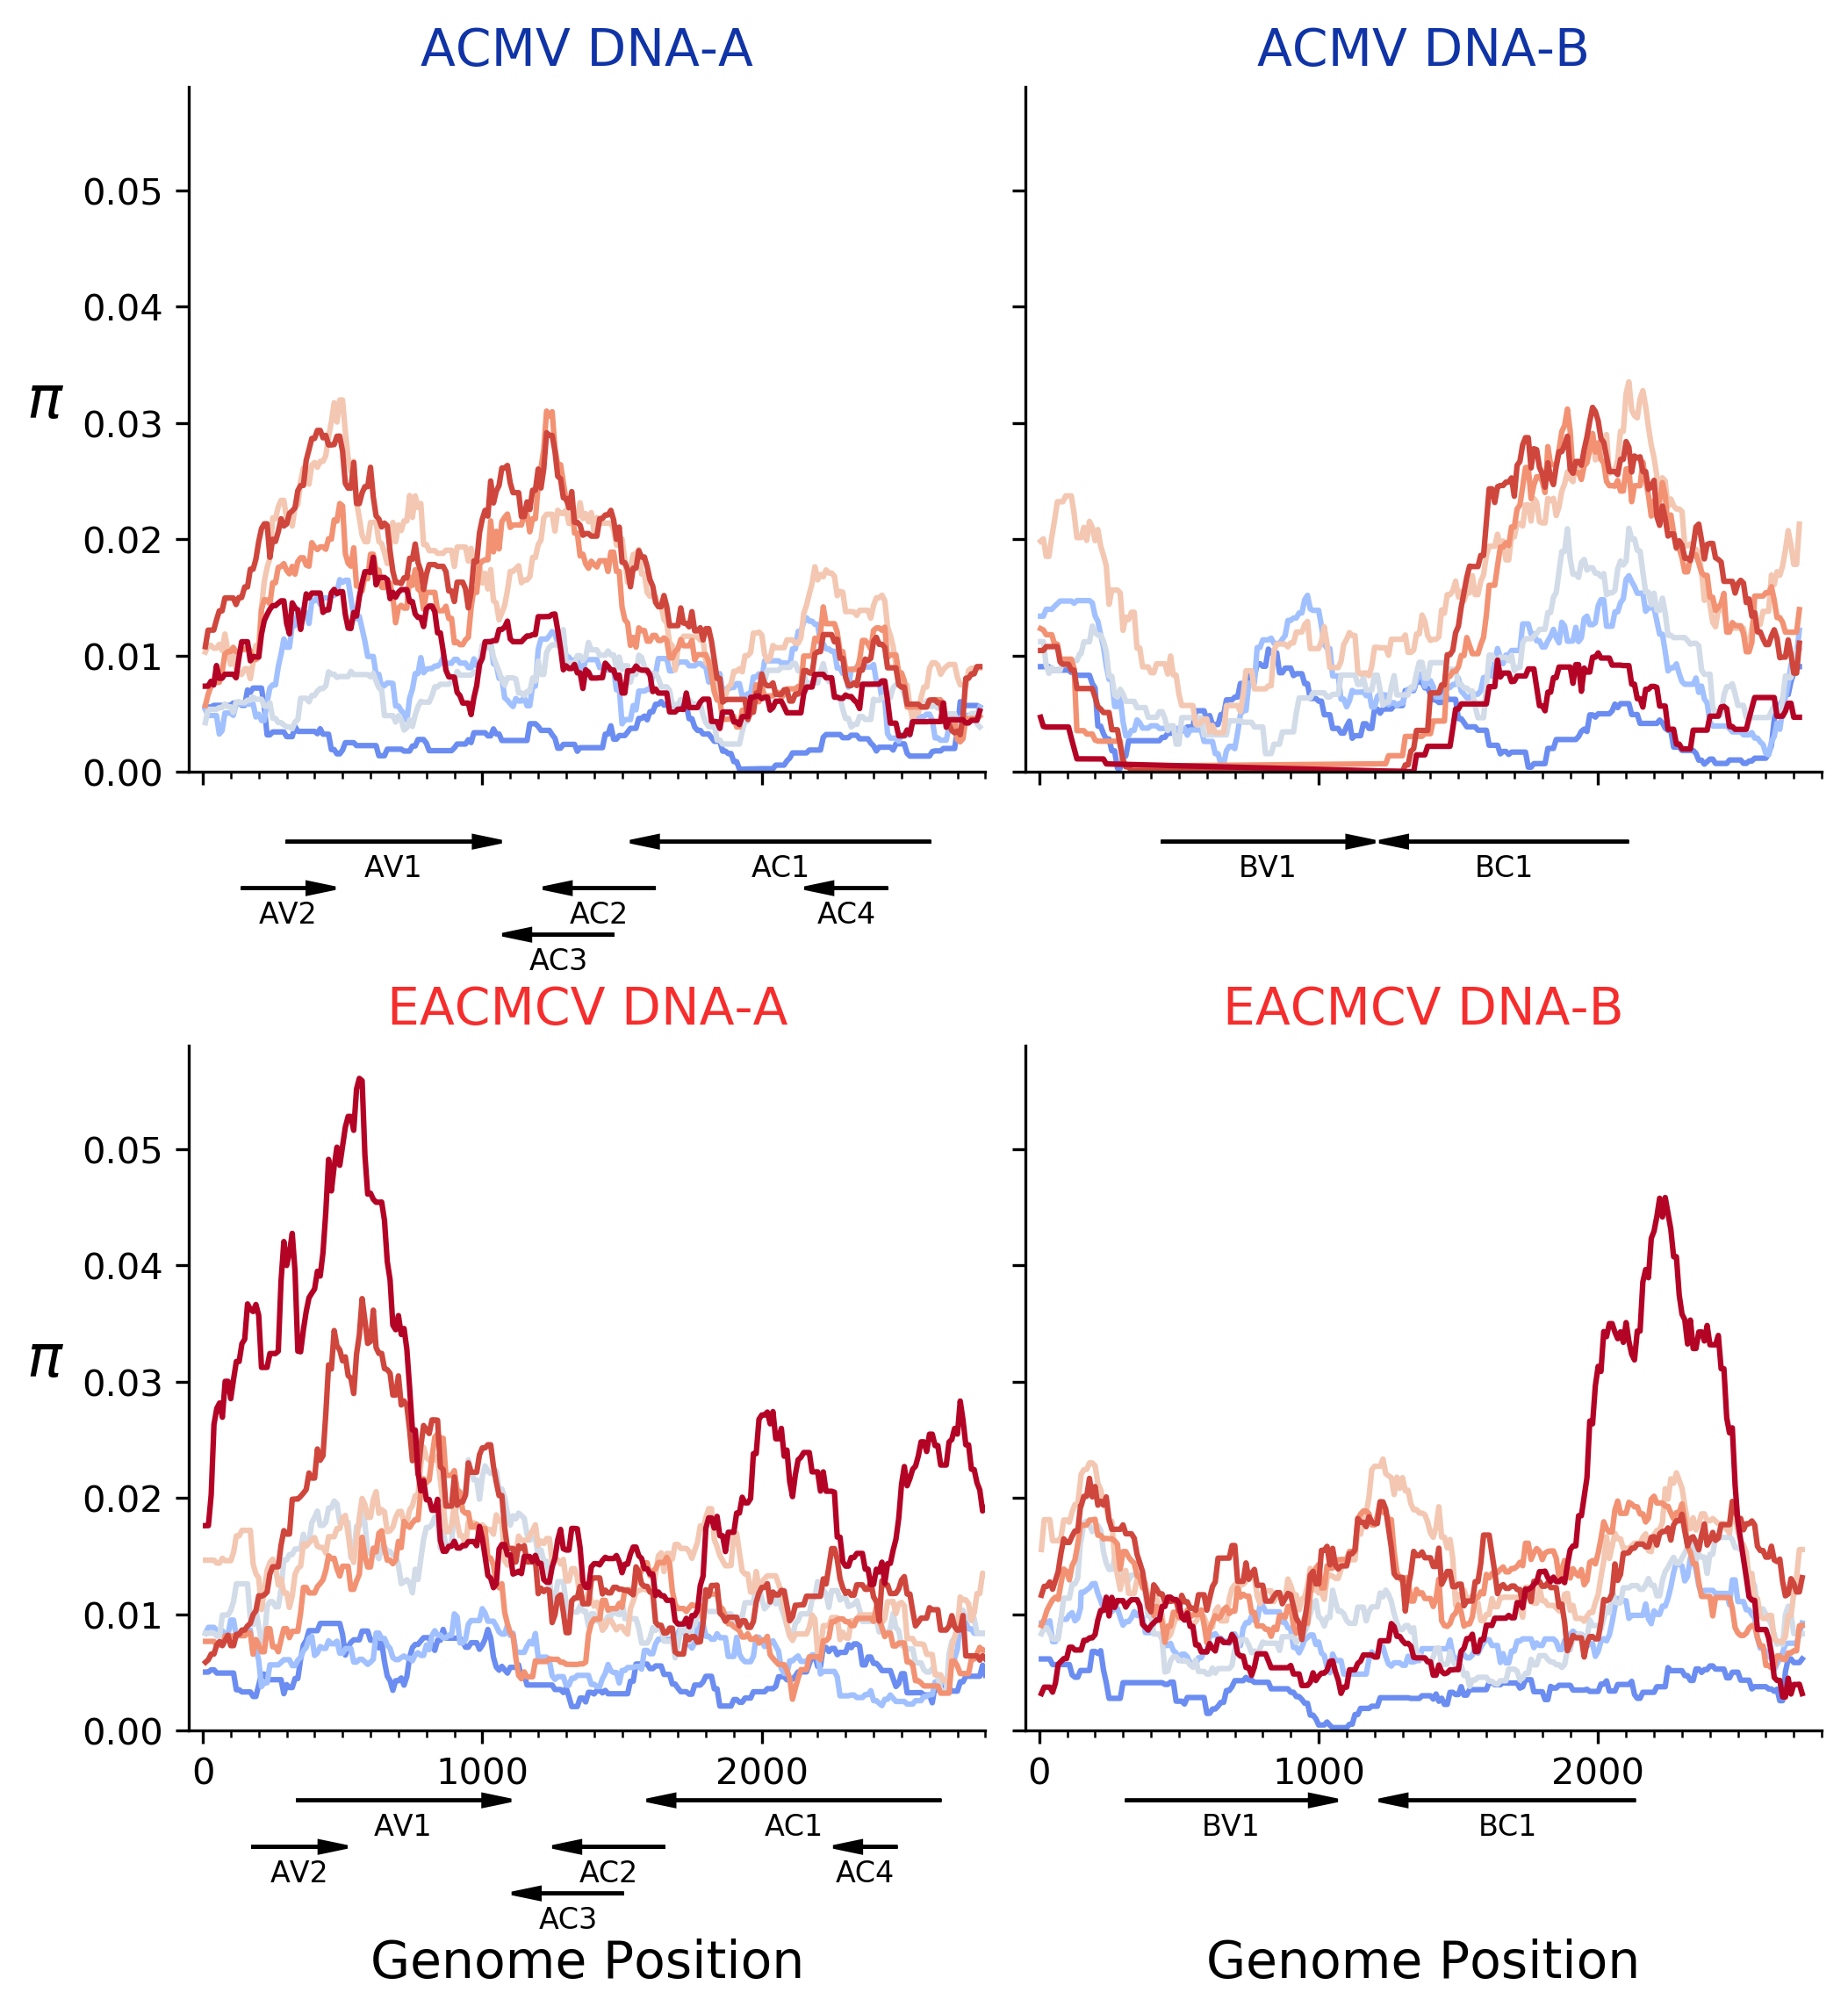

In [24]:
#create a plot area in <fig> with subplots in <axes>
#2,2 is the number of subplots horizontally,vertically (so 2X2)
#figsize is figure outer dimnsions in inches
#sharey and sharex are set to true to automatically set all subplots to the same scales and prints labels only on the outsides
fig,axes = plt.subplots(2,2,figsize=(8,8),sharey=True,sharex=True,dpi=300)

x = 'window'
y='pi_per_site'

rainbow = ['violet','indigo','b','g','yellow','orange','r'] # cm.get_cmap('hsv',7) #
colors = ['b','r','y','k','g','grey','orange']
binary = cm.get_cmap('binary', 10)
coolwarm = cm.get_cmap('coolwarm', 14)

#colors=['b','r','k']

#each subplot can be accessed by its coordinate in <axes>
#ax= instructs the plot function to send the output to a target subplot, rather than a new figure
#loop through the data for each passage, and plot a line for each segment in the appropritate subplot
for passage in veg_windows.passage.unique(): #[1,4,7]
    
    #r = rainbow.pop()
    #c=colors.pop()
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'ACMV DNA-A'].plot(y=y,x=x,
                                                                        ax=axes[0,0],
                                                                        color=coolwarm(passage*2),
                                                                        legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'ACMV DNA-B'].plot(y=y,x=x,
                                                                        ax=axes[0,1],
                                                                        color=coolwarm(passage*2),
                                                                        legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'EACMCV DNA-A'].plot(y=y,x=x,
                                                                          ax=axes[1,0],
                                                                          color=coolwarm(passage*2),
                                                                          legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'EACMCV DNA-B'].plot(y=y,x=x,
                                                                          ax=axes[1,1],
                                                                          color=coolwarm(passage*2),
                                                                          legend=False)

fix_genomes_fig()
plt.show()


### Window size = 300bp, step 10bp
### Passages: 1-7:blue to red
___

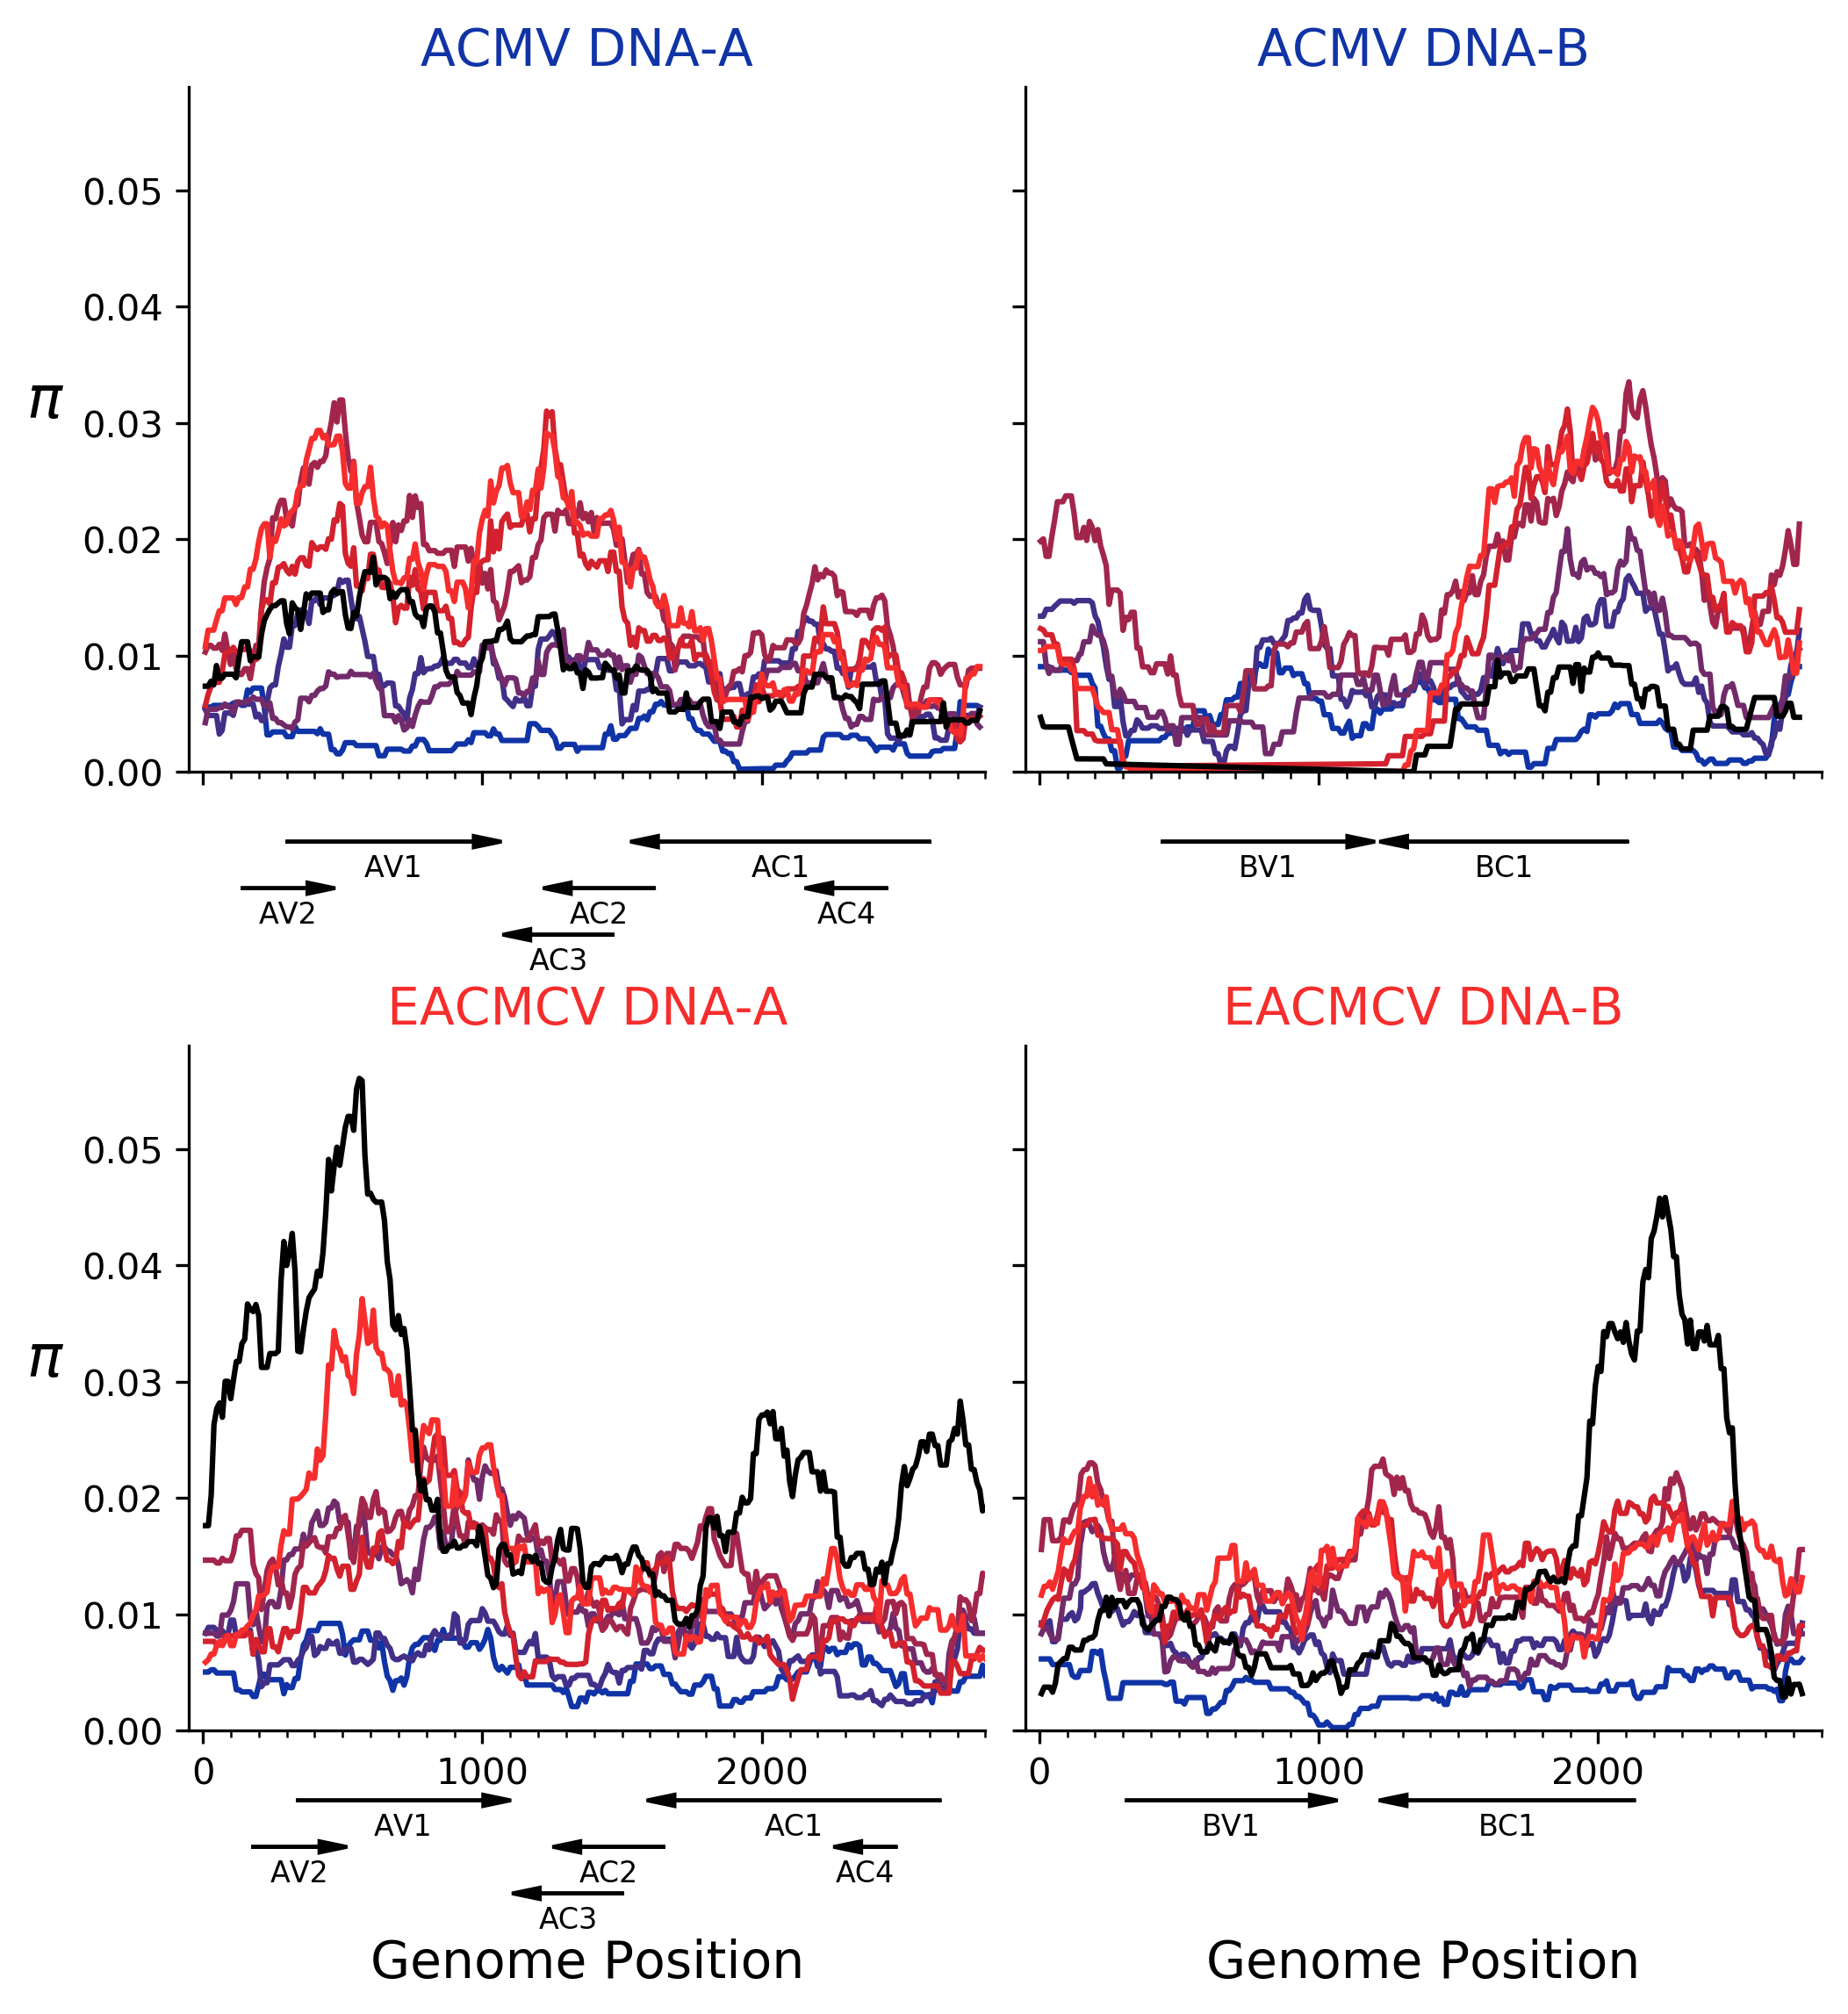

In [25]:
#create a plot area in <fig> with subplots in <axes>
#2,2 is the number of subplots horizontally,vertically (so 2X2)
#figsize is figure outer dimnsions in inches
#sharey and sharex are set to true to automatically set all subplots to the same scales and prints labels only on the outsides
fig,axes = plt.subplots(2,2,figsize=(8,8),sharey=True,sharex=True,dpi=300)

x = 'window'
y='pi_per_site'

blue_red = ['#1034a6','#412f88','#722b6a','#a2264b','#d3212d','#f62d2d','k']

#colors=['b','r','k']

#each subplot can be accessed by its coordinate in <axes>
#ax= instructs the plot function to send the output to a target subplot, rather than a new figure
#loop through the data for each passage, and plot a line for each segment in the appropritate subplot
for passage in veg_windows.passage.unique(): #[1,4,7]
    
    c= blue_red[passage-1]
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'ACMV DNA-A'].plot(y=y,x=x,
                                                                        ax=axes[0,0],
                                                                        color=c,
                                                                        legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'ACMV DNA-B'].plot(y=y,x=x,
                                                                        ax=axes[0,1],
                                                                        color=c,
                                                                        legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'EACMCV DNA-A'].plot(y=y,x=x,
                                                                          ax=axes[1,0],
                                                                          color=c,
                                                                          legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'EACMCV DNA-B'].plot(y=y,x=x,
                                                                          ax=axes[1,1],
                                                                          color=c,
                                                                          legend=False)

fix_genomes_fig()
plt.show()

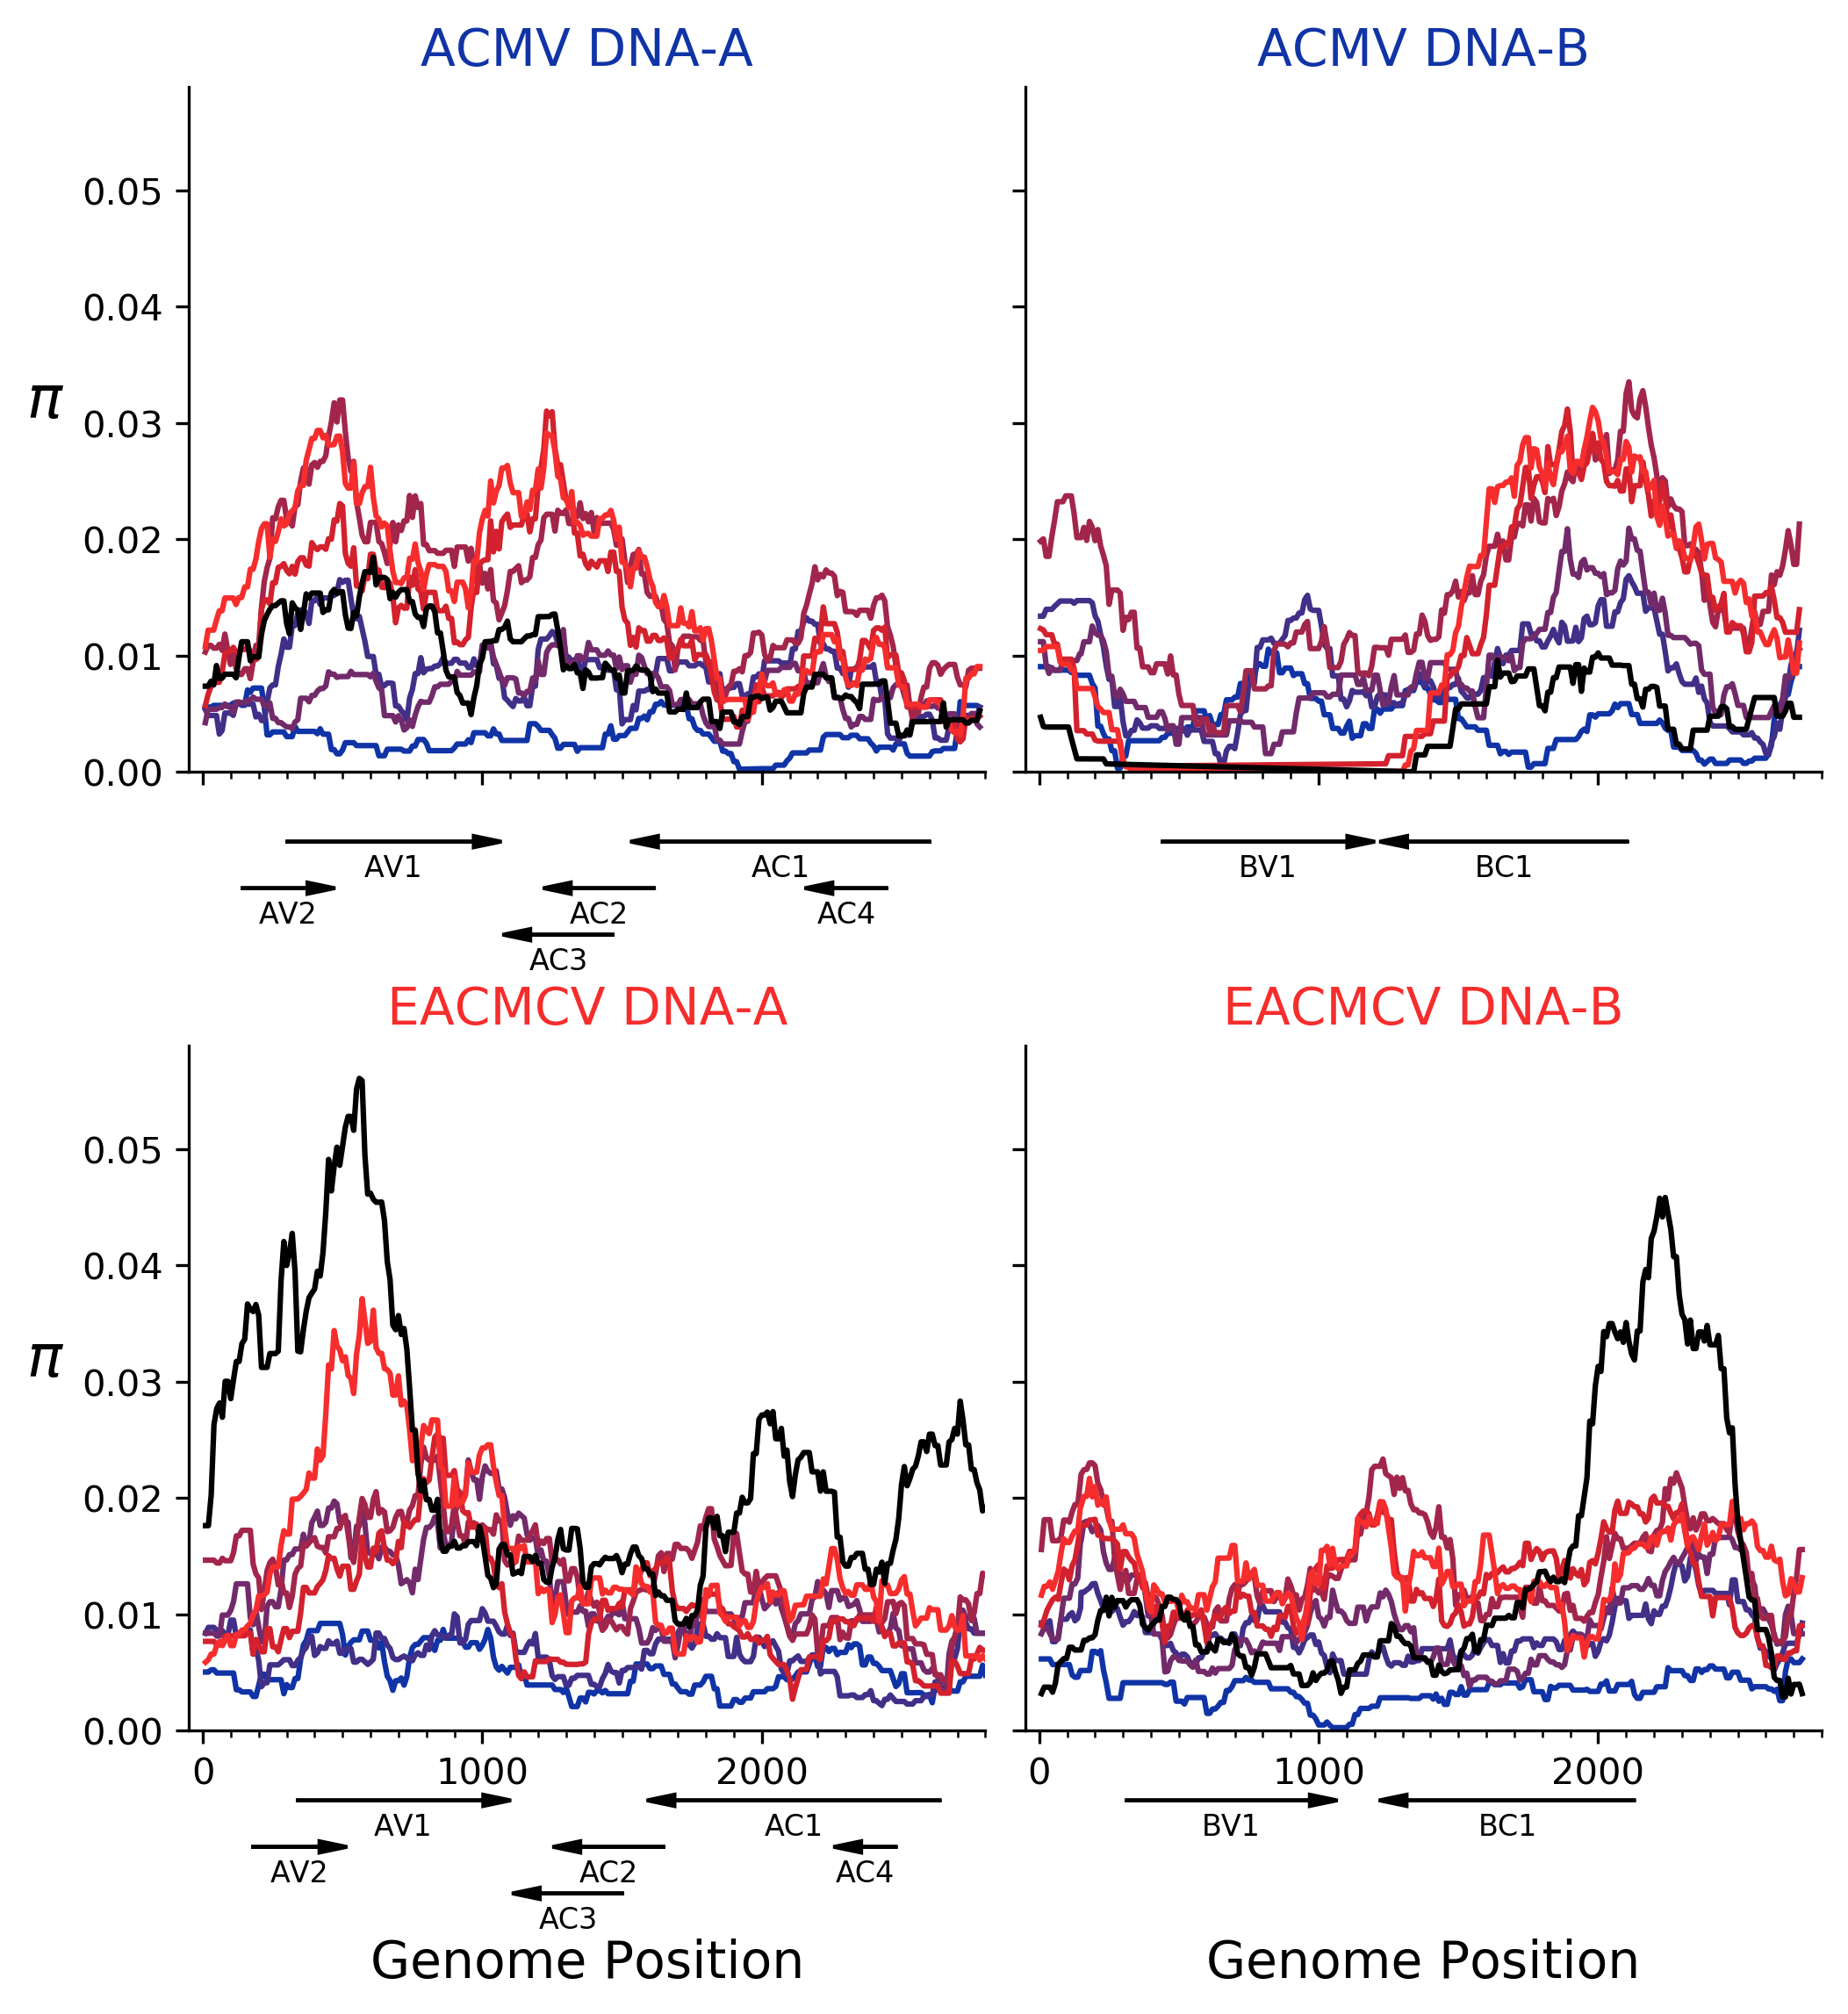

In [26]:
#create a plot area in <fig> with subplots in <axes>
#2,2 is the number of subplots horizontally,vertically (so 2X2)
#figsize is figure outer dimnsions in inches
#sharey and sharex are set to true to automatically set all subplots to the same scales and prints labels only on the outsides
fig,axes = plt.subplots(2,2,figsize=(8,8),sharey=True,sharex=True,dpi=300)

x = 'window'
y='pi_per_site'

blue_red = ['#1034a6','#412f88','#722b6a','#a2264b','#d3212d','#f62d2d','k']

#colors=['b','r','k']

#each subplot can be accessed by its coordinate in <axes>
#ax= instructs the plot function to send the output to a target subplot, rather than a new figure
#loop through the data for each passage, and plot a line for each segment in the appropritate subplot
for passage in veg_windows.passage.unique(): #[1,4,7]
    
    c= blue_red[passage-1]
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'ACMV DNA-A'].plot(y=y,x=x,
                                                                        ax=axes[0,0],
                                                                        color=c,
                                                                        legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'ACMV DNA-B'].plot(y=y,x=x,
                                                                        ax=axes[0,1],
                                                                        color=c,
                                                                        legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'EACMCV DNA-A'].plot(y=y,x=x,
                                                                          ax=axes[1,0],
                                                                          color=c,
                                                                          legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'EACMCV DNA-B'].plot(y=y,x=x,
                                                                          ax=axes[1,1],
                                                                          color=c,
                                                                          legend=False)

fix_genomes_fig()
plt.show()

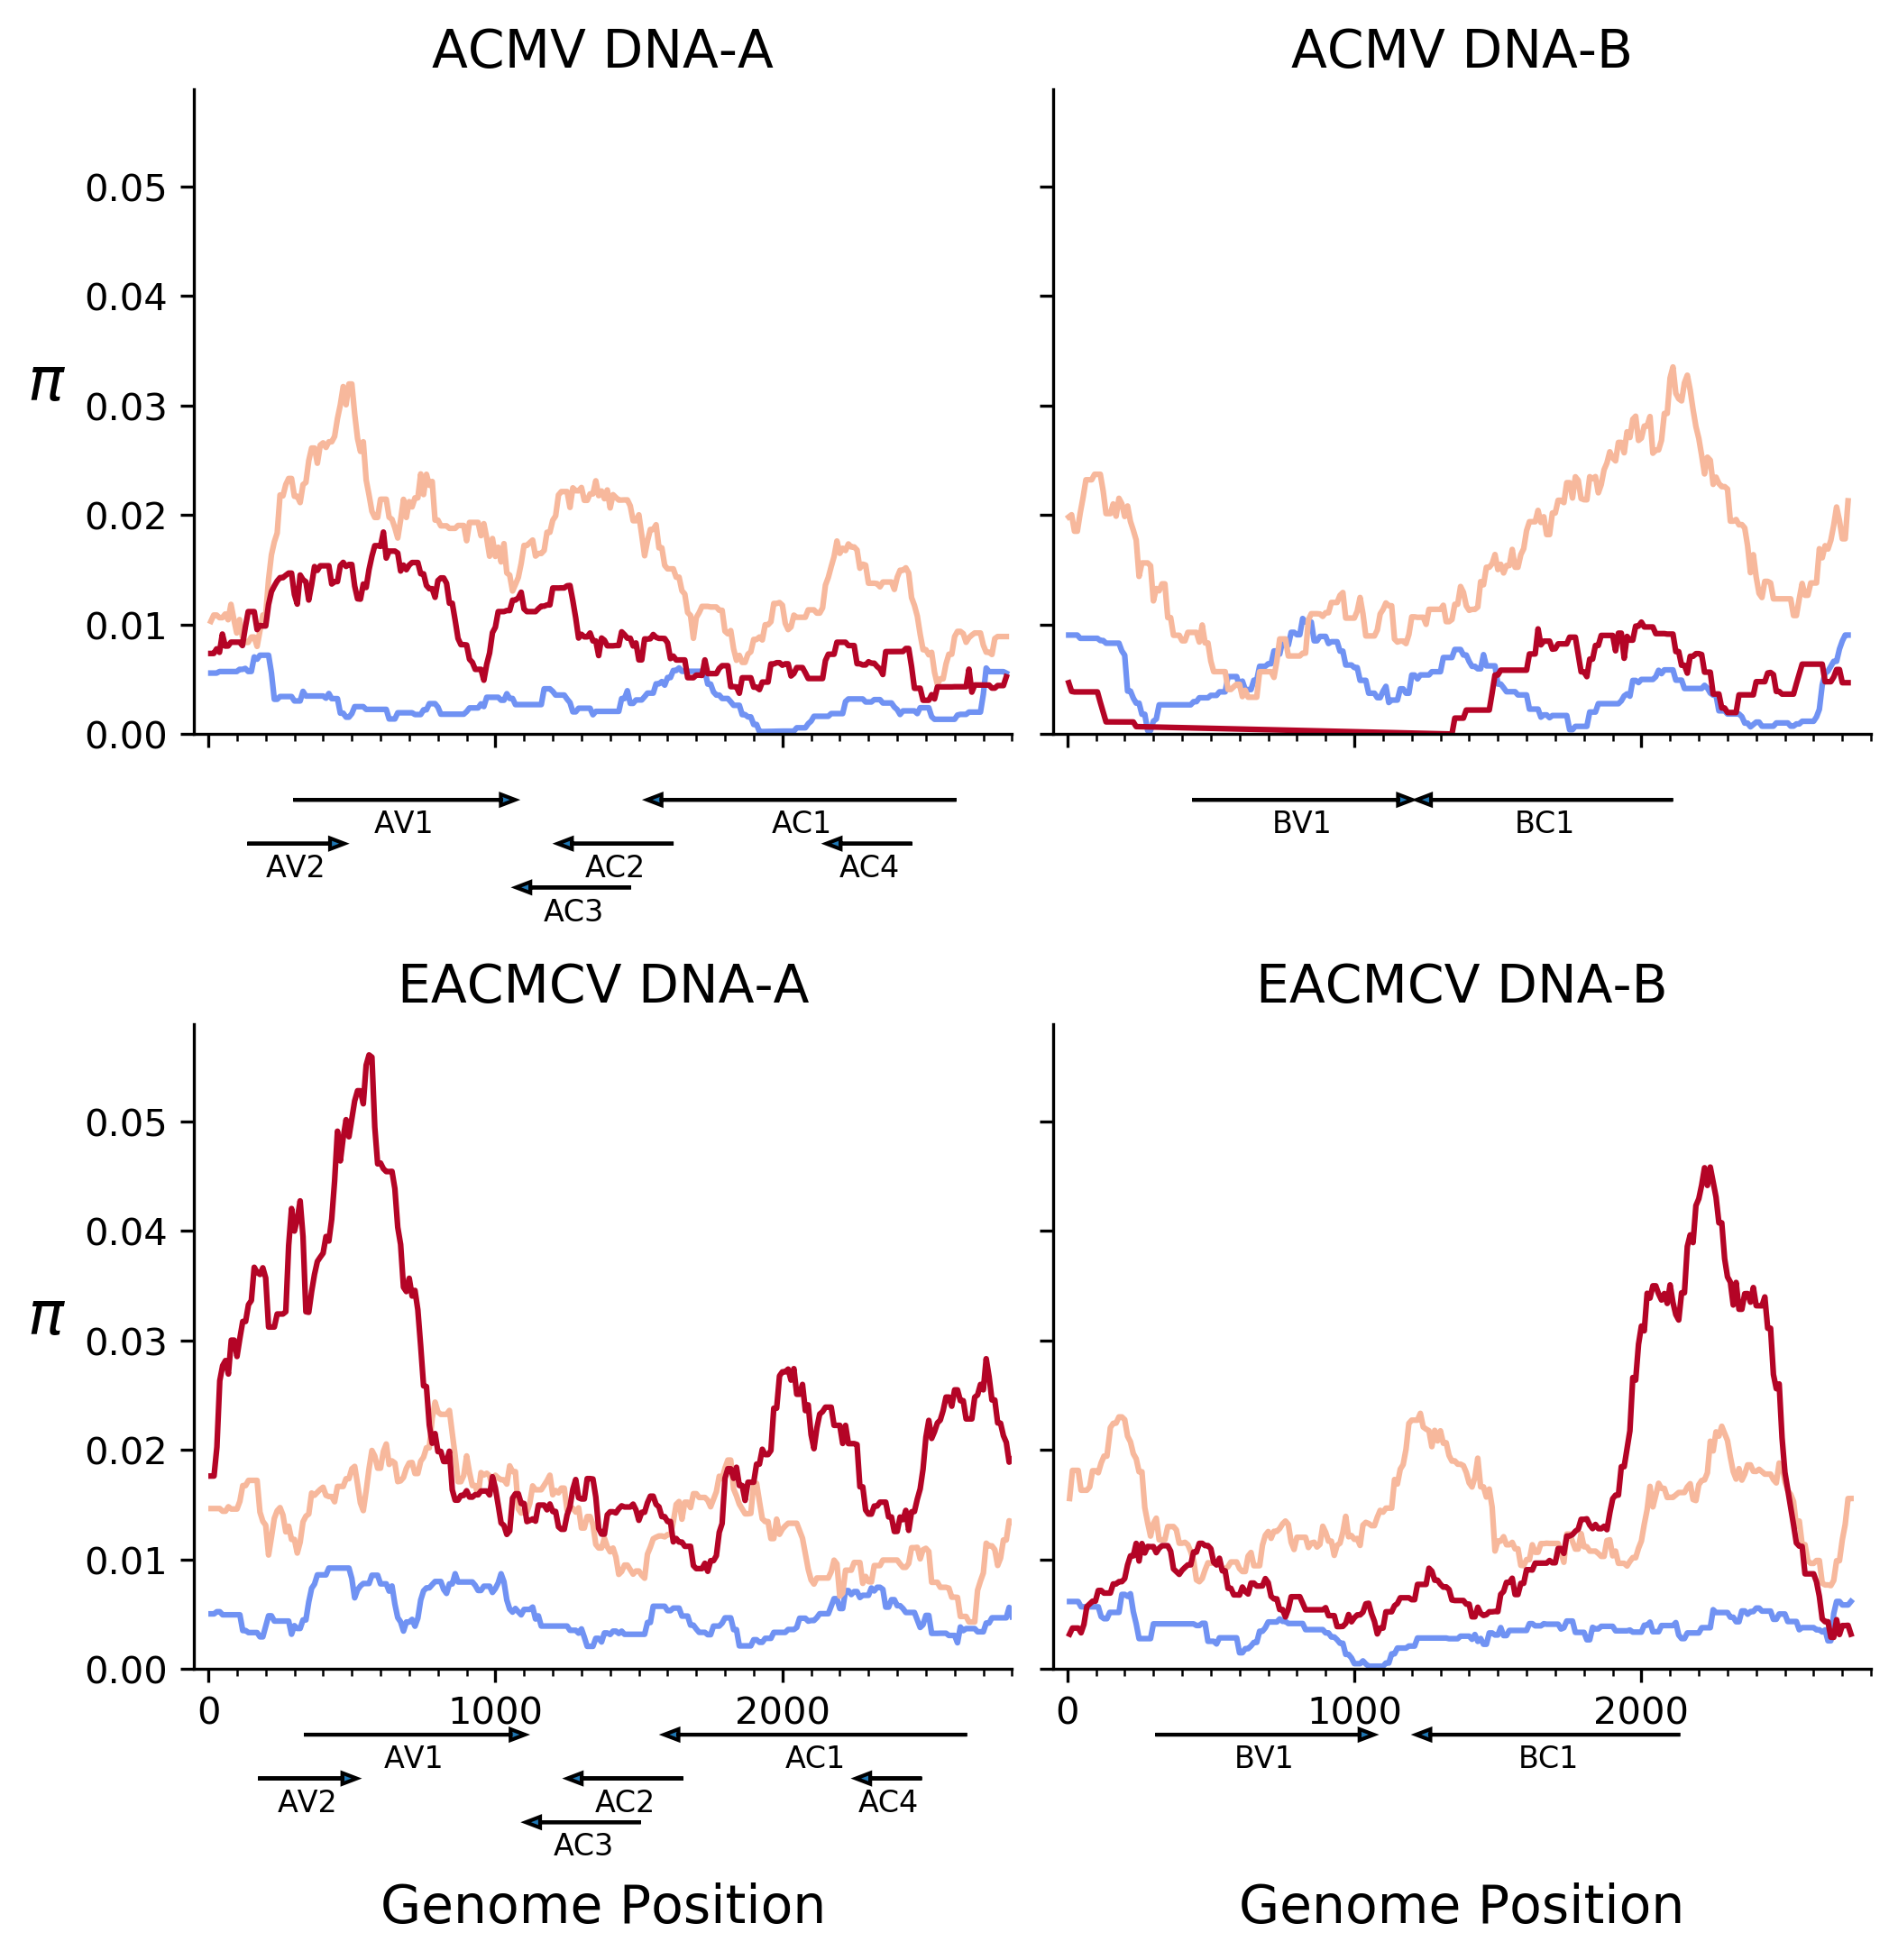

In [27]:
#create a plot area in <fig> with subplots in <axes>
#2,2 is the number of subplots horizontally,vertically (so 2X2)
#figsize is figure outer dimnsions in inches
#sharey and sharex are set to true to automatically set all subplots to the same scales and prints labels only on the outsides
fig,axes = plt.subplots(2,2,figsize=(8,8),sharey=True,sharex=True,dpi=300)

x = 'window'
y='pi_per_site'

rainbow = cm.get_cmap('hsv',7) #['violet','indigo','b','g','y','orange','r']
colors = ['b','r','y','k','g','grey','orange']
binary = cm.get_cmap('binary', 7)
coolwarm = cm.get_cmap('coolwarm', 7)

#colors=['b','r','k']

#each subplot can be accessed by its coordinate in <axes>
#ax= instructs the plot function to send the output to a target subplot, rather than a new figure
#loop through the data for each passage, and plot a line for each segment in the appropritate subplot
for passage in [1,4,7]: #veg_windows.passage.unique()
    
    #r = rainbow.pop()
    #c=colors.pop()
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'ACMV DNA-A'].plot(y=y,x=x,
                                                                        ax=axes[0,0],
                                                                        color=coolwarm(passage),
                                                                        legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'ACMV DNA-B'].plot(y=y,x=x,
                                                                        ax=axes[0,1],
                                                                        color=coolwarm(passage),
                                                                        legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'EACMCV DNA-A'].plot(y=y,x=x,
                                                                          ax=axes[1,0],
                                                                          color=coolwarm(passage),
                                                                          legend=False)
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'EACMCV DNA-B'].plot(y=y,x=x,
                                                                          ax=axes[1,1],
                                                                          color=coolwarm(passage),
                                                                          legend=False)

    
#genome maps  
def draw_map(data,axes):
    
    width = 0
    y = [-0.006,-0.010,-0.014]
    annot = [-0.009,-0.013,-0.017]
    
    for ind in data.index:
    
        if data.loc[ind,'region'] != 'IGR5':
            
            if data.loc[ind,'direction'].lower() == 'c':
                x = data.loc[ind,'stop']
                dx = -(data.loc[ind,'stop']-data.loc[ind,'start'])
            
            else:
                x = data.loc[ind,'start']
                dx = data.loc[ind,'stop']-data.loc[ind,'start']
            
                if data.loc[ind,'direction'].lower() == 'n':
                    width = 0
                    
            if data.loc[ind,'region'] in ['AC1','AV1','BC1','BV1']:
                row = 0 
            
            elif data.loc[ind,'region'] in ['AV2','AC2','AC4']:
                row = 1
                
            else:
                row = 2
        
            axes.arrow(x=x,
              y=y[row],
              dx=dx,
              dy=0,
              width=np.abs(width),
              length_includes_head=True,
              head_width=0.001,
              head_length=50,
              shape='full',
              overhang=0,
              head_starts_at_zero=False,
              fill=True,
              clip_on=False,
              ec='k')
    
            axes.annotate(s=data.loc[ind,'region'],
                        xy=(((2*x+dx)/2),annot[row]),
                        ha='center',
                        fontsize=8,
                        annotation_clip=False)
    
    return

#draw and annotate gene regions 
draw_map(regions.loc[regions.chrom == 'ACMV DNA-A'],axes[0,0])
draw_map(regions.loc[regions.chrom == 'ACMV DNA-B'],axes[0,1])
draw_map(regions.loc[regions.chrom == 'EACMCV DNA-A'],axes[1,0])
draw_map(regions.loc[regions.chrom == 'EACMCV DNA-B'],axes[1,1])


#genome_map(regions.loc[regions.chrom == 'ACMV DNA-A'],ax=axes[0,0],y=-0.2)
    
xlim = axes[0,0].get_xlim()
ylim = axes[0,0].get_ylim()

axes[0,0].set_ylim(0,ylim[1])
axes[0,0].set_xlim(-50,2800)

#set the title for each subplot
axes[0,0].set_title('ACMV DNA-A',fontsize=14)
axes[0,1].set_title('ACMV DNA-B',fontsize=14)    
axes[1,0].set_title('EACMCV DNA-A',fontsize=14)    
axes[1,1].set_title('EACMCV DNA-B',fontsize=14)

#set x and y labels at appropriate subplots for the figure
axes[1,0].set_xlabel('Genome Position',fontsize=14)
axes[1,1].set_xlabel('Genome Position',fontsize=14)
axes[0,0].set_ylabel(r'$\pi$',fontsize=16, rotation=0)
axes[1,0].set_ylabel(r'$\pi$',fontsize=16, rotation=0)
axes[1,0].xaxis.labelpad = 40
axes[1,1].xaxis.labelpad = 40
axes[0,0].yaxis.labelpad = 10
axes[1,0].yaxis.labelpad = 10


#turn on minor ticks on the x axis
axes[1,0].xaxis.set_major_locator(MultipleLocator(1000))
axes[1,0].xaxis.set_minor_locator(AutoMinorLocator(10))

#remove the subplot borders on the right
for ax1 in axes:
    for ax2 in ax1:
        ax2.spines['right'].set_visible(False)

#remove the subplot borders on the top
for ax1 in axes:
    for ax2 in ax1:
        ax2.spines['top'].set_visible(False)
        
plt.subplots_adjust(bottom=0.15,hspace=0.45, wspace=0.05)

#show the plot
plt.show() 

Use the 300bp width, 10bp step pi data to zoom in on AC1 and AV1 gene regions 

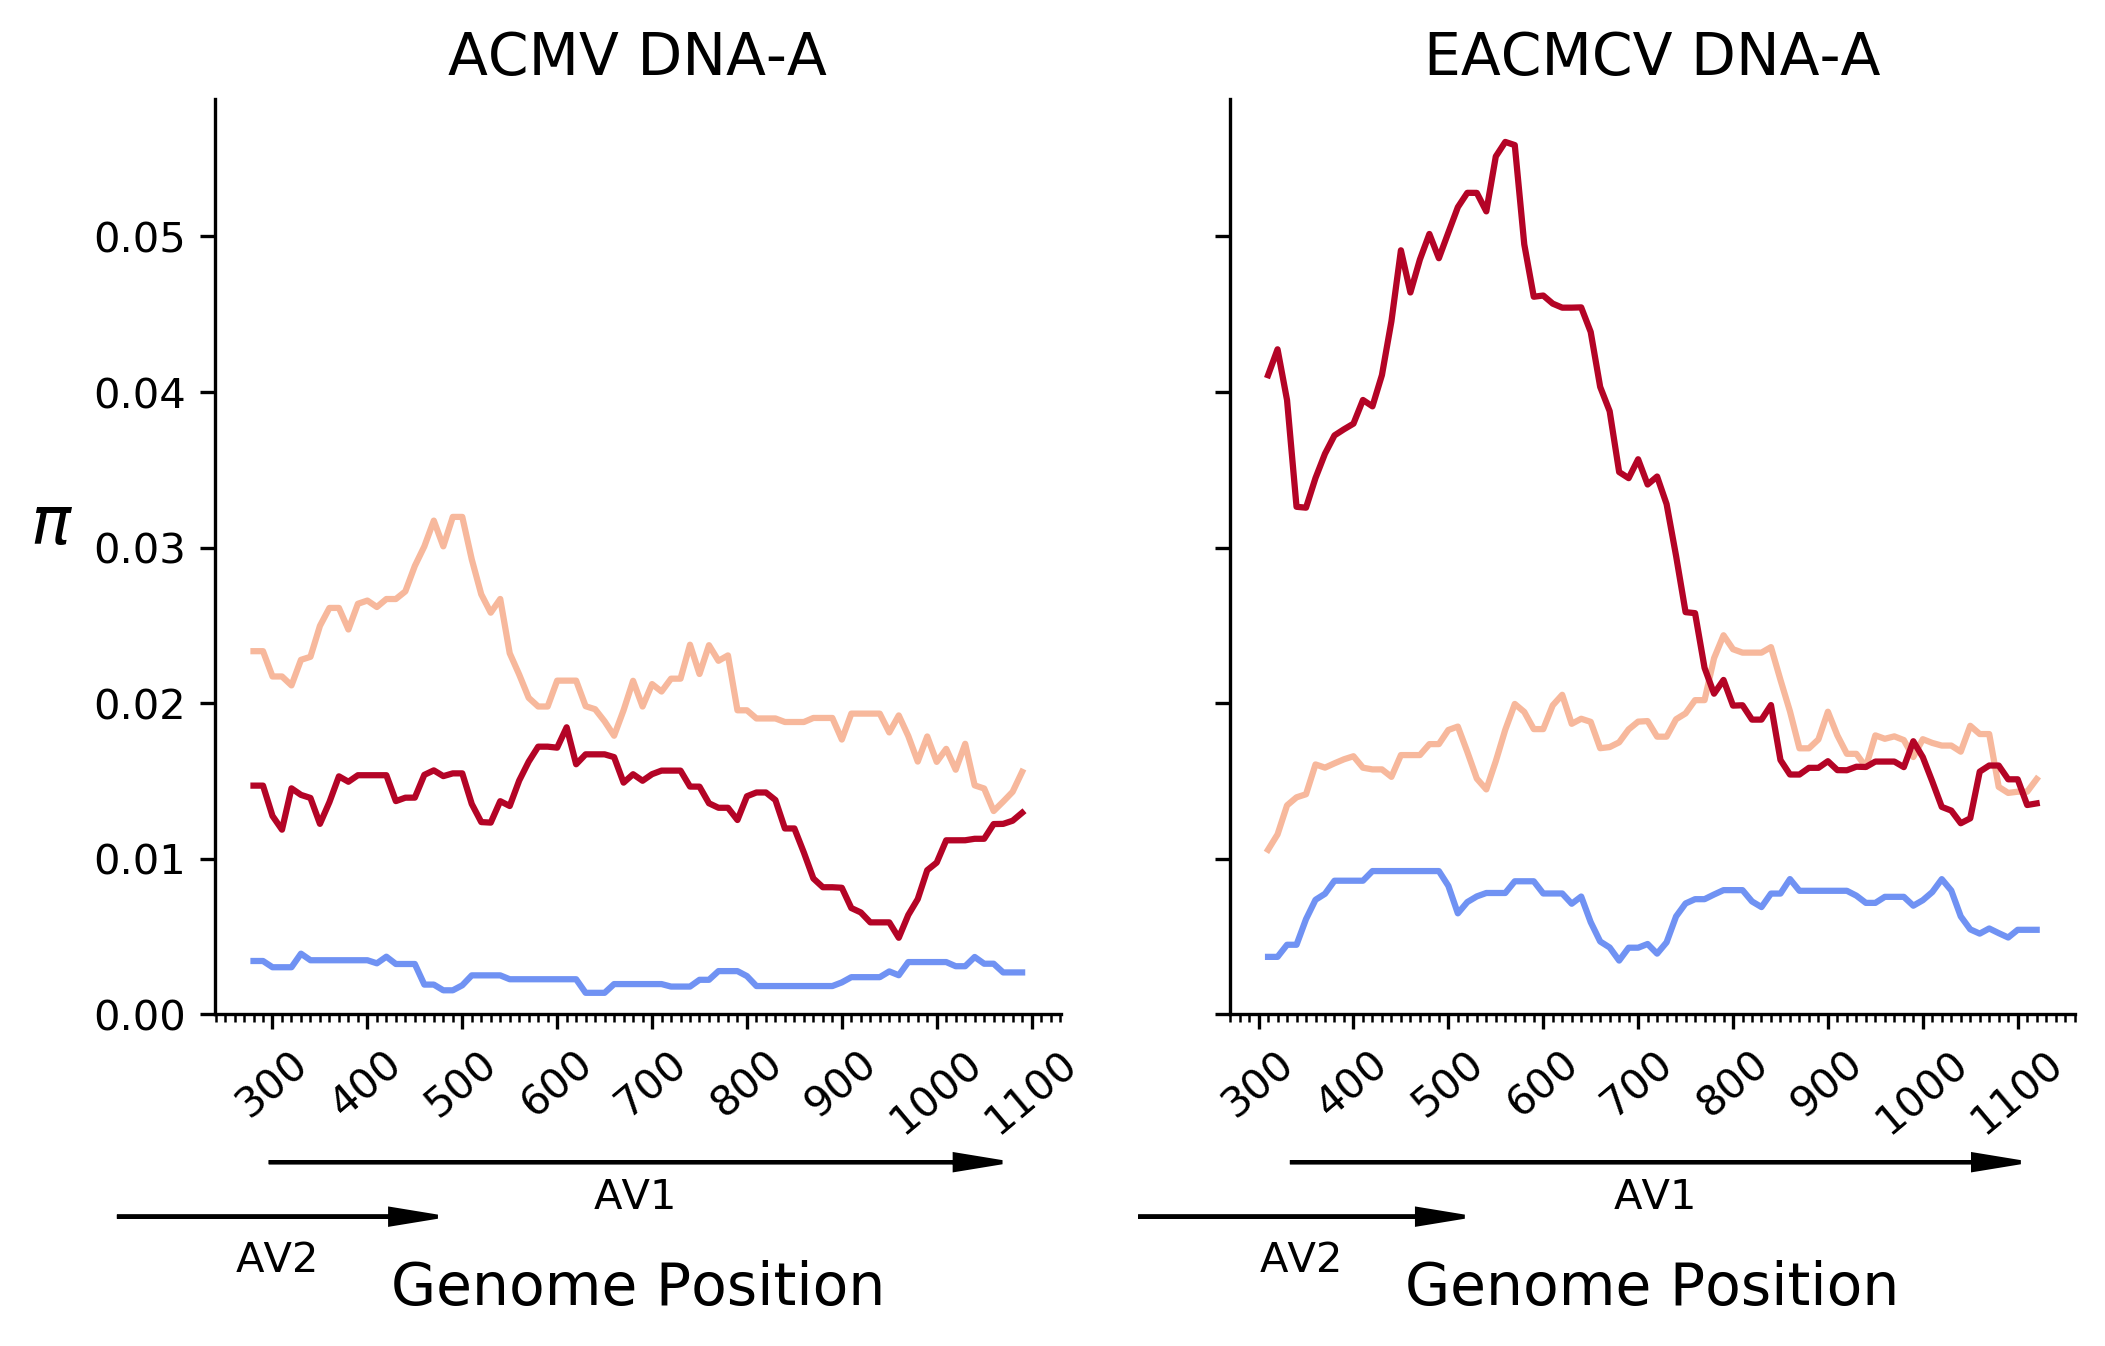

In [28]:
#create a plot area in <fig> with subplots in <axes>
#2,2 is the number of subplots horizontally,vertically (so 2X2)
#figsize is figure outer dimnsions in inches
#sharey and sharex are set to true to automatically set all subplots to the same scales and prints labels only on the outsides
fig,axes = plt.subplots(1,2,figsize=(8,5),sharey=True,sharex=False,dpi=300)

x = 'window'
y='pi_per_site'

coolwarm = cm.get_cmap('coolwarm', 7)
#each subplot can be accessed by its coordinate in <axes>
#ax= instructs the plot function to send the output to a target subplot, rather than a new figure
#loop through the data for each passage, and plot a line for each segment in the appropritate subplot
for passage in [1,4,7]:#veg_windows.passage.unique():
    
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'ACMV DNA-A'].loc[veg_windows.window >= 280].loc[veg_windows.window <= 1090].plot(y=y,x=x,
                                                                        ax=axes[0],
                                                                        color=coolwarm(passage),
                                                                        legend=False)
    
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'EACMCV DNA-A'].loc[veg_windows.window >= 310].loc[veg_windows.window <= 1120].plot(y=y,x=x,
                                                                          ax=axes[1],
                                                                          color=coolwarm(passage),
                                                                          legend=False)
    
#genome maps  
def draw_map(data,axes):
    
    width = 0
    y = [-0.0095,-0.013,-0.016]
    annot = [-0.0125,-0.0165,-0.0165]
    
    for ind in data.index:
    
        if data.loc[ind,'region'] in ['AV1','AV2']:
            
            if data.loc[ind,'direction'].lower() == 'c':
                x = data.loc[ind,'stop']
                dx = -(data.loc[ind,'stop']-data.loc[ind,'start'])
            
            else:
                x = data.loc[ind,'start']
                dx = data.loc[ind,'stop']-data.loc[ind,'start']
            
                if data.loc[ind,'direction'].lower() == 'n':
                    width = 0
                    
            if data.loc[ind,'region'] in ['AV1']:
                row = 0 
            
            elif data.loc[ind,'region'] in ['AV2']:
                row = 1
        
            axes.arrow(x=x,
              y=y[row],
              dx=dx,
              dy=0,
              width=0,
              length_includes_head=True,
              head_width=0.001,
              head_length=50,
              shape='full',
              overhang=0,
              head_starts_at_zero=False,
              fill=True,
              clip_on=False,
              fc='k')
    
            axes.annotate(s=data.loc[ind,'region'],
                        xy=(((2*x+dx)/2),annot[row]),
                        ha='center',
                        fontsize=10,
                        annotation_clip=False)
    
    return

#draw and annotate gene regions 
draw_map(regions.loc[regions.chrom == 'ACMV DNA-A'],axes[0])
draw_map(regions.loc[regions.chrom == 'EACMCV DNA-A'],axes[1])

#genome_map(regions.loc[regions.chrom == 'ACMV DNA-A'],ax=axes[0,0],y=-0.2)
    
xlim = axes[0].get_xlim()
ylim = axes[0].get_ylim()

axes[0].set_ylim(0,ylim[1])

#set the title for each subplot
axes[0].set_title('ACMV DNA-A',fontsize=14) 
axes[1].set_title('EACMCV DNA-A',fontsize=14)    

#set x and y labels at appropriate subplots for the figure
axes[1].set_xlabel('Genome Position',fontsize=14)
axes[0].set_xlabel('Genome Position',fontsize=14)
axes[0].set_ylabel(r'$\pi$',fontsize=16, rotation=0)
axes[0].xaxis.labelpad = 28
axes[1].xaxis.labelpad = 28
axes[0].yaxis.labelpad = 10

#turn on minor ticks on the x axis
axes[0].xaxis.set_major_locator(MultipleLocator(100))
axes[0].xaxis.set_minor_locator(AutoMinorLocator(10))
axes[1].xaxis.set_major_locator(MultipleLocator(100))
axes[1].xaxis.set_minor_locator(AutoMinorLocator(10))
axes[0].xaxis.set_tick_params(rotation=40)
axes[1].xaxis.set_tick_params(rotation=40)

#remove the subplot borders on the right
for ax1 in axes:
    ax1.spines['right'].set_visible(False)

#remove the subplot borders on the top
for ax1 in axes:
    ax1.spines['top'].set_visible(False)  

plt.subplots_adjust(bottom=0.27)

#show the plot
plt.show() 

## Window size = 300bp, step 10bp
### Passages 1,4,7: cool to warm

Repeat for AC1:

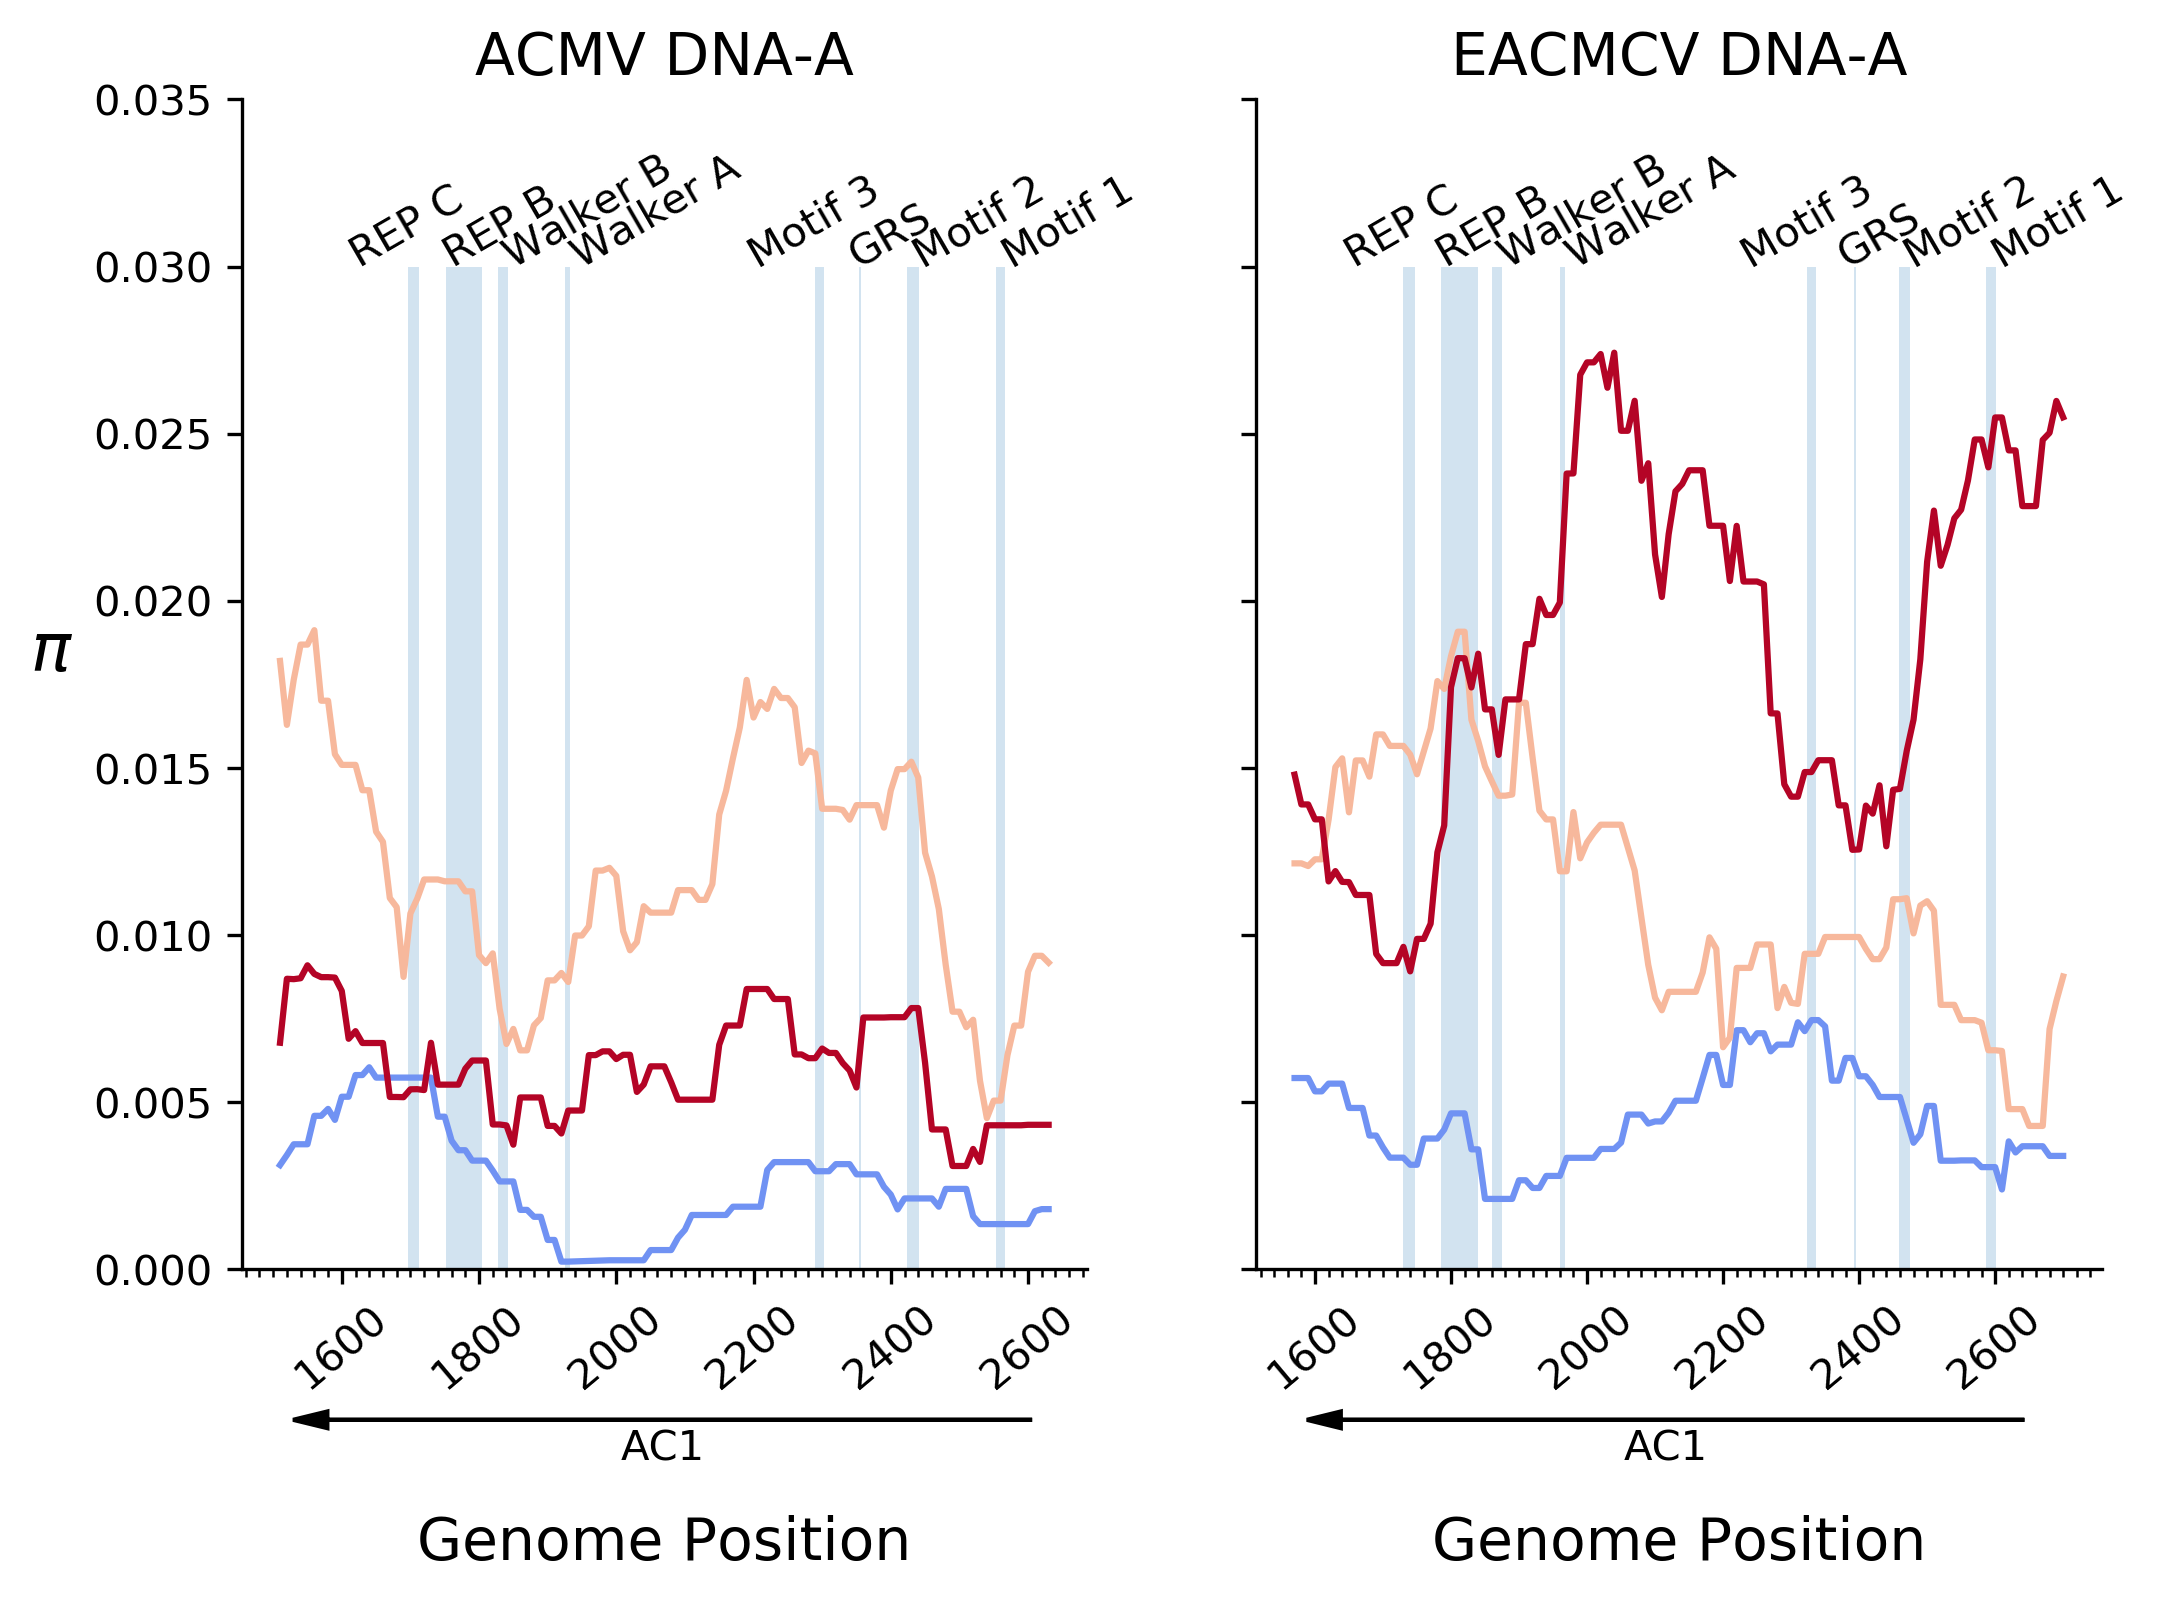

In [29]:
#create a plot area in <fig> with subplots in <axes>
#2,2 is the number of subplots horizontally,vertically (so 2X2)
#figsize is figure outer dimnsions in inches
#sharey and sharex are set to true to automatically set all subplots to the same scales and prints labels only on the outsides
fig,axes = plt.subplots(1,2,figsize=(8,5),sharey=True,sharex=False,dpi=300)

x = 'window'
y='pi_per_site'

coolwarm = cm.get_cmap('coolwarm', 7)
#each subplot can be accessed by its coordinate in <axes>
#ax= instructs the plot function to send the output to a target subplot, rather than a new figure
#loop through the data for each passage, and plot a line for each segment in the appropritate subplot
for passage in [1,4,7]: #veg_windows.passage.unique():
    
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'ACMV DNA-A'].loc[veg_windows.window >= 1510].loc[veg_windows.window <= 2630].plot(y=y,x=x,
                                                                        ax=axes[0],
                                                                        color=coolwarm(passage),
                                                                        legend=False)
    
    veg_windows.loc[veg_windows.passage == passage].loc[veg_windows.chrom == 'EACMCV DNA-A'].loc[veg_windows.window >= 1570].loc[veg_windows.window <= 2700].plot(y=y,x=x,
                                                                          ax=axes[1],
                                                                          color=coolwarm(passage),
                                                                          legend=False)
    
#genome maps  
def draw_map(data,axes):
    
    width = 0
    y = [-0.0045,-0.0004,-0.012]
    annot = [-0.0057,-0.0045,-0.0125]
    
    for ind in data.index:
    
        if data.loc[ind,'region'] in ['AC1']:
            
            if data.loc[ind,'direction'].lower() == 'c':
                x = data.loc[ind,'stop']
                dx = -(data.loc[ind,'stop']-data.loc[ind,'start'])
            
            else:
                x = data.loc[ind,'start']
                dx = data.loc[ind,'stop']-data.loc[ind,'start']
            
                if data.loc[ind,'direction'].lower() == 'n':
                    width = 0
                    
            if data.loc[ind,'region'] in ['AC1']:
                row = 0 
            
            elif data.loc[ind,'region'] in ['AC2']:
                row = 1
        
            axes.arrow(x=x,
              y=y[row],
              dx=dx,
              dy=0,
              width=0,
              length_includes_head=True,
              head_width=0.0005,
              head_length=50,
              shape='full',
              overhang=0,
              head_starts_at_zero=False,
              fill=True,
              clip_on=False,
              fc='k')
    
            axes.annotate(s=data.loc[ind,'region'],
                        xy=(((2*x+dx)/2),annot[row]),
                        ha='center',
                        fontsize=10,
                        annotation_clip=False)
    
    return

#draw and annotate gene regions 
draw_map(regions.loc[regions.chrom == 'ACMV DNA-A'],axes[0])
draw_map(regions.loc[regions.chrom == 'EACMCV DNA-A'],axes[1])

#genome_map(regions.loc[regions.chrom == 'ACMV DNA-A'],ax=axes[0,0],y=-0.2)
    
xlim = axes[0].get_xlim()
ylim = axes[0].get_ylim()

axes[0].set_ylim(0,0.035)

#set the title for each subplot
axes[0].set_title('ACMV DNA-A',fontsize=14) 
axes[1].set_title('EACMCV DNA-A',fontsize=14)    

#set x and y labels at appropriate subplots for the figure
axes[1].set_xlabel('Genome Position',fontsize=14)
axes[0].set_xlabel('Genome Position',fontsize=14)
axes[0].set_ylabel(r'$\pi$',fontsize=16, rotation=0)
axes[0].xaxis.labelpad = 28
axes[1].xaxis.labelpad = 28
axes[0].yaxis.labelpad = 10

#turn on minor ticks on the x axis
axes[0].xaxis.set_major_locator(MultipleLocator(200))
axes[0].xaxis.set_minor_locator(AutoMinorLocator(10))
axes[1].xaxis.set_major_locator(MultipleLocator(200))
axes[1].xaxis.set_minor_locator(AutoMinorLocator(10))
axes[0].xaxis.set_tick_params(rotation=40)
axes[1].xaxis.set_tick_params(rotation=40)

#remove the subplot borders on the right
for ax1 in axes:
    ax1.spines['right'].set_visible(False)

#remove the subplot borders on the top
for ax1 in axes:
    ax1.spines['top'].set_visible(False)  
    
#draw motifs
motif_y = 0.030

#ACMV------------------------------------
#RepB
axes[0].add_patch(
            patch.Rectangle(
            (1752,0),
            width=53,
            height=motif_y,
            fill=True,
            alpha=0.2)
            )
axes[0].text(1740,motif_y,"REP B",rotation=30,horizontalalignment='left')

#RepC
axes[0].add_patch(
            patch.Rectangle(
            (1696,0),
            width=16,
            height=motif_y,
            fill=True,
            alpha=0.2)
            )
axes[0].text(1696,motif_y,"REP C",rotation=30,horizontalalignment='center')

#WalkerA
axes[0].add_patch(
            patch.Rectangle(
            (1926,0),
            width=7,
            height=motif_y,
            fill=True,
            alpha=0.2)
            )
axes[0].text(1926,motif_y,"Walker A",rotation=30,horizontalalignment='left')

#WalkerB
axes[0].add_patch(
            patch.Rectangle(
            (1827,0),
            width=15,
            height=motif_y,
            fill=True,
            alpha=0.2)
            )
axes[0].text(1827,motif_y,"Walker B",rotation=30,horizontalalignment='left')

#Motif1
axes[0].add_patch(
            patch.Rectangle(
            (2553,0),
            width=14,
            height=motif_y,
            fill=True,
            alpha=0.2)
            )
axes[0].text(2553,motif_y,"Motif 1",rotation=30,horizontalalignment='left')

#Motif2
axes[0].add_patch(
            patch.Rectangle(
            (2424,0),
            width=17,
            height=motif_y,
            fill=True,
            alpha=0.2)
            )
axes[0].text(2424,motif_y,"Motif 2",rotation=30,horizontalalignment='left')

#GRS
axes[0].add_patch(
            patch.Rectangle(
            (2353,0),
            width=3,
            height=motif_y,
            fill=True,
            alpha=0.2)
            )
axes[0].text(2330,motif_y,"GRS",rotation=30,horizontalalignment='left')

#Motif3
axes[0].add_patch(
            patch.Rectangle(
            (2289,0),
            width=14,
            height=motif_y,
            fill=True,
            alpha=0.2)
            )
axes[0].text(2289,motif_y,"Motif 3",rotation=30,horizontalalignment='center')

#EACMCV------------------
#WalkerA
axes[1].add_patch(
            patch.Rectangle(
            (1960,0),
            width=8,
            height=motif_y,
            fill=True,
            alpha=0.2)
            )
axes[1].text(1960,motif_y,"Walker A",rotation=30,horizontalalignment='left')

#WalkerB
axes[1].add_patch(
            patch.Rectangle(
            (1861,0),
            width=14,
            height=motif_y,
            fill=True,
            alpha=0.2)
            )
axes[1].text(1861,motif_y,"Walker B",rotation=30,horizontalalignment='left')

#Motif1
axes[1].add_patch(
            patch.Rectangle(
            (2587,0),
            width=14,
            height=motif_y,
            fill=True,
            alpha=0.2)
            )
axes[1].text(2587,motif_y,"Motif 1",rotation=30,horizontalalignment='left')

#Motif2
axes[1].add_patch(
            patch.Rectangle(
            (2458,0),
            width=17,
            height=motif_y,
            fill=True,
            alpha=0.2)
            )
axes[1].text(2458,motif_y,"Motif 2",rotation=30,horizontalalignment='left')

#GRS
axes[1].add_patch(
            patch.Rectangle(
            (2392,0),
            width=3,
            height=motif_y,
            fill=True,
            alpha=0.2)
            )
axes[1].text(2360,motif_y,"GRS",rotation=30,horizontalalignment='left')

#Motif3
axes[1].add_patch(
            patch.Rectangle(
            (2324,0),
            width=13,
            height=motif_y,
            fill=True,
            alpha=0.2)
            )
axes[1].text(2324,motif_y,"Motif 3",rotation=30,horizontalalignment='center')


#RepB
axes[1].add_patch(
            patch.Rectangle(
            (1786,0),
            width=53,
            height=motif_y,
            fill=True,
            alpha=0.2)
            )
axes[1].text(1770,motif_y,"REP B",rotation=30,horizontalalignment='left')

#RepC
axes[1].add_patch(
            patch.Rectangle(
            (1729,0),
            width=18,
            height=motif_y,
            fill=True,
            alpha=0.2)
            )
axes[1].text(1729,motif_y,"REP C",rotation=30,horizontalalignment='center')

plt.subplots_adjust(bottom=0.1)
#include grs b/t motif2&3
#show the plot
plt.show() 

In [ ]:
domains = pd.read_csv('Domains_2.csv',header=0)
domains

## Window size = 300bp, step 10bp
### Passages: 1-Orange, 2-Grey, 3-Green, 4-Black, 5-Yellow, 6-Red, 7-Blue